In [1]:
!nvidia-smi

Thu Feb 29 19:25:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   34C    P8              22W / 215W |   1239MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [8]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [9]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [10]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M13sinc as M13

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m14sinc.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M14sinc', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': True, 'learnable_windows': False, 'shared_window': True, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [18]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                 | 0.003278688524590164/10 [00:00<34:17, 205.81s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.429343
Mem before-during-after: 1692160 3965101568 26915328


  1%|▍                                 | 0.13442622950819672/10 [00:18<22:23, 136.22s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 1.375422
Mem before-during-after: 26915328 3981580800 27796992


  3%|▉                                 | 0.26557377049180286/10 [00:34<18:50, 116.16s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 0.756204
Mem before-during-after: 27040256 3980154880 26915328


  4%|█▍                                   | 0.39672131147541/10 [00:50<22:15, 139.02s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 0.910358
Mem before-during-after: 27796992 3980142080 26915328


  5%|█▊                                 | 0.5278688524590167/10 [01:07<17:57, 113.74s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.011180
Mem before-during-after: 26915328 3947177984 26915328


  7%|██▎                                | 0.6590163934426216/10 [01:24<19:48, 127.20s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 1.015143
Mem before-during-after: 26915328 3923291648 27367936


  8%|██▊                                | 0.7901639344262266/10 [01:42<20:57, 136.51s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 1.260892
Mem before-during-after: 26915328 3980478464 26915328


 10%|███▌                                | 0.9999999999999944/10 [01:57<11:38, 77.61s/it]


Test Epoch: 1	Accuracy: 610/976 (62%)



 10%|███▌                                | 1.0032786885245846/10 [01:57<13:46, 91.87s/it]

Train Epoch: 2 [0/3918 (0%)]	Loss: 0.982668
Mem before-during-after: 26914304 3978381312 26915328


 11%|███▉                               | 1.1344262295081895/10 [02:12<16:32, 111.95s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.525100
Mem before-during-after: 26915328 3982147072 26915328


 13%|████▍                              | 1.2655737704917944/10 [02:29<19:05, 131.10s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 0.992562
Mem before-during-after: 26915328 3556338688 27614720


 14%|████▉                              | 1.3967213114753994/10 [02:44<18:44, 130.71s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 0.712643
Mem before-during-after: 26915328 3980374528 26915328


 15%|█████▎                             | 1.5278688524590043/10 [03:01<18:48, 133.15s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 1.199487
Mem before-during-after: 27796992 3954020352 26974720


 17%|█████▊                             | 1.6590163934426092/10 [03:18<18:33, 133.47s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 1.108662
Mem before-during-after: 26915328 3981023744 27796992


 18%|██████▎                            | 1.7901639344262141/10 [03:34<18:16, 133.51s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 1.370133
Mem before-during-after: 26915328 3982471680 26915328


 20%|███████▍                             | 1.999999999999982/10 [03:48<08:31, 63.94s/it]


Test Epoch: 2	Accuracy: 595/976 (61%)



 20%|███████▏                            | 2.0032786885245724/10 [03:49<10:33, 79.20s/it]

Train Epoch: 3 [0/3918 (0%)]	Loss: 0.905951
Mem before-during-after: 26914304 3978256896 26915328


 21%|███████▍                           | 2.1344262295081773/10 [04:06<19:31, 148.92s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 1.133121
Mem before-during-after: 27105792 3980213248 27796992


 23%|████████▏                           | 2.265573770491782/10 [04:24<17:32, 136.12s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 0.824851
Mem before-during-after: 26915328 3980374528 26915328


 24%|████████▋                           | 2.396721311475387/10 [04:41<17:13, 135.98s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 0.559502
Mem before-during-after: 27796992 3981023744 27796992


 25%|█████████                           | 2.527868852458992/10 [04:58<16:29, 132.36s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 1.135304
Mem before-during-after: 26915328 3922839040 26915328


 27%|█████████▌                          | 2.659016393442597/10 [05:14<16:04, 131.39s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 0.941408
Mem before-during-after: 26915328 3980374528 26915328


 28%|██████████                          | 2.790163934426202/10 [05:31<15:55, 132.53s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 0.876671
Mem before-during-after: 26915328 3953398272 26915328


 30%|███████████▍                          | 2.99999999999997/10 [05:45<07:33, 64.85s/it]


Test Epoch: 3	Accuracy: 575/976 (59%)



 30%|███████████▍                          | 3.00655737704915/10 [05:46<08:26, 72.49s/it]

Train Epoch: 4 [0/3918 (0%)]	Loss: 0.971075
Mem before-during-after: 26914304 3978256384 26915328


 31%|███████████▎                        | 3.134426229508165/10 [06:03<14:48, 129.40s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 0.613061
Mem before-during-after: 26915328 3981378560 26915328


 33%|████████████                         | 3.26557377049177/10 [06:20<15:07, 134.82s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 0.780303
Mem before-during-after: 26915328 3981023744 27796992


 34%|███████████▉                       | 3.3967213114753747/10 [06:36<13:13, 120.19s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 0.942948
Mem before-during-after: 26915328 3980496896 26915328


 35%|████████████▎                      | 3.5278688524589796/10 [06:53<14:29, 134.36s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 1.106081
Mem before-during-after: 27796992 3980699136 26915328


 37%|████████████▊                      | 3.6590163934425846/10 [07:09<14:03, 132.95s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 0.929779
Mem before-during-after: 26915328 3981580800 27796992


 38%|█████████████▎                     | 3.7901639344261895/10 [07:25<11:31, 111.43s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 0.848006
Mem before-during-after: 26915328 3980049920 26915328


 40%|██████████████▍                     | 3.9999999999999574/10 [07:39<06:01, 60.23s/it]


Test Epoch: 4	Accuracy: 570/976 (58%)



 40%|██████████████▍                     | 4.0032786885245475/10 [07:39<07:54, 79.14s/it]

Train Epoch: 5 [0/3918 (0%)]	Loss: 1.201425
Mem before-during-after: 26914304 3978256384 26915328


 41%|██████████████▉                     | 4.134426229508152/10 [07:56<12:22, 126.53s/it]

Train Epoch: 5 [640/3918 (16%)]	Loss: 0.850068
Mem before-during-after: 27040256 3981889536 26915328


 43%|███████████████▎                    | 4.265573770491757/10 [08:13<13:44, 143.83s/it]

Train Epoch: 5 [1280/3918 (33%)]	Loss: 0.884505
Mem before-during-after: 26915328 3980898816 26915328


 44%|███████████████▊                    | 4.396721311475362/10 [08:30<12:35, 134.74s/it]

Train Epoch: 5 [1920/3918 (49%)]	Loss: 1.210244
Mem before-during-after: 26915328 3980374528 26915328


 45%|████████████████▎                   | 4.527868852458967/10 [08:48<12:27, 136.56s/it]

Train Epoch: 5 [2560/3918 (66%)]	Loss: 0.842971
Mem before-during-after: 27796992 3980699136 26915328


 47%|████████████████▊                   | 4.659016393442572/10 [09:04<10:02, 112.80s/it]

Train Epoch: 5 [3200/3918 (82%)]	Loss: 0.840352
Mem before-during-after: 26915328 3980374528 26915328


 48%|█████████████████▏                  | 4.790163934426177/10 [09:20<10:44, 123.72s/it]

Train Epoch: 5 [3840/3918 (98%)]	Loss: 1.058915
Mem before-during-after: 26915328 3980049920 26915328


 50%|██████████████████▍                  | 4.999999999999945/10 [09:34<05:09, 61.80s/it]


Test Epoch: 5	Accuracy: 542/976 (55%)



 50%|██████████████████▌                  | 5.003278688524535/10 [09:34<06:25, 77.14s/it]

Train Epoch: 6 [0/3918 (0%)]	Loss: 1.023236
Mem before-during-after: 26914304 3978256384 26915328


 51%|██████████████████▉                  | 5.13442622950814/10 [09:51<10:42, 132.14s/it]

Train Epoch: 6 [640/3918 (16%)]	Loss: 1.026408
Mem before-during-after: 26915328 3981023744 27796992


 53%|██████████████████▉                 | 5.265573770491745/10 [10:07<10:24, 131.80s/it]

Train Epoch: 6 [1280/3918 (33%)]	Loss: 0.824441
Mem before-during-after: 26915328 3980374528 26915328


 54%|███████████████████▉                 | 5.39672131147535/10 [10:23<08:28, 110.39s/it]

Train Epoch: 6 [1920/3918 (49%)]	Loss: 1.074875
Mem before-during-after: 26915328 3980049920 26915328


 55%|███████████████████▉                | 5.527868852458955/10 [10:38<08:13, 110.33s/it]

Train Epoch: 6 [2560/3918 (66%)]	Loss: 0.720739
Mem before-during-after: 26915328 3980049920 26915328


 57%|████████████████████▉                | 5.65901639344256/10 [10:53<08:59, 124.18s/it]

Train Epoch: 6 [3200/3918 (82%)]	Loss: 1.017917
Mem before-during-after: 26915328 3980699136 26915328


 58%|████████████████████▊               | 5.790163934426165/10 [11:10<08:10, 116.45s/it]

Train Epoch: 6 [3840/3918 (98%)]	Loss: 0.963451
Mem before-during-after: 26915328 3980049920 26915328


 60%|█████████████████████▌              | 5.9999999999999325/10 [11:23<04:04, 61.21s/it]


Test Epoch: 6	Accuracy: 570/976 (58%)



 60%|██████████████████████▏              | 6.003278688524523/10 [11:24<05:10, 77.58s/it]

Train Epoch: 7 [0/3918 (0%)]	Loss: 0.629676
Mem before-during-after: 26914304 3978256384 26915328


 61%|█████████████████████▍             | 6.1344262295081275/10 [11:41<09:29, 147.45s/it]

Train Epoch: 7 [640/3918 (16%)]	Loss: 1.090678
Mem before-during-after: 26915328 3978381312 26915328


 63%|█████████████████████▉             | 6.2655737704917325/10 [11:58<08:14, 132.33s/it]

Train Epoch: 7 [1280/3918 (33%)]	Loss: 0.874084
Mem before-during-after: 26915328 3982796288 26915328


 64%|███████████████████████             | 6.396721311475337/10 [12:15<06:43, 111.98s/it]

Train Epoch: 7 [1920/3918 (49%)]	Loss: 0.910938
Mem before-during-after: 26915328 3980699136 26915328


 65%|███████████████████████▌            | 6.527868852458942/10 [12:31<07:44, 133.66s/it]

Train Epoch: 7 [2560/3918 (66%)]	Loss: 0.661743
Mem before-during-after: 26915328 3981023744 27796992


 67%|███████████████████████▉            | 6.659016393442547/10 [12:47<07:01, 126.28s/it]

Train Epoch: 7 [3200/3918 (82%)]	Loss: 0.832378
Mem before-during-after: 26915328 3980608512 26915328


 68%|████████████████████████▍           | 6.790163934426152/10 [13:03<05:57, 111.25s/it]

Train Epoch: 7 [3840/3918 (98%)]	Loss: 1.121505
Mem before-during-after: 26915328 3981023744 27796992


 70%|██████████████████████████▌           | 6.99999999999992/10 [13:17<03:03, 61.04s/it]


Test Epoch: 7	Accuracy: 536/976 (55%)



 70%|██████████████████████████▌           | 7.00327868852451/10 [13:17<03:52, 77.68s/it]

Train Epoch: 8 [0/3918 (0%)]	Loss: 0.989986
Mem before-during-after: 26914304 3978256384 26915328


 71%|█████████████████████████▋          | 7.134426229508115/10 [13:32<05:31, 115.71s/it]

Train Epoch: 8 [640/3918 (16%)]	Loss: 0.915287
Mem before-during-after: 26915328 3729697792 26915328


 73%|██████████████████████████▉          | 7.26557377049172/10 [13:48<05:04, 111.40s/it]

Train Epoch: 8 [1280/3918 (33%)]	Loss: 1.698415
Mem before-during-after: 26915328 3980374528 26915328


 74%|██████████████████████████▋         | 7.396721311475325/10 [14:05<05:23, 124.39s/it]

Train Epoch: 8 [1920/3918 (49%)]	Loss: 0.789488
Mem before-during-after: 27796992 3924959744 26915328


 75%|███████████████████████████▊         | 7.52786885245893/10 [14:21<05:31, 134.26s/it]

Train Epoch: 8 [2560/3918 (66%)]	Loss: 0.913505
Mem before-during-after: 27849216 3980466688 27239936


 77%|███████████████████████████▌        | 7.659016393442535/10 [14:37<04:49, 123.59s/it]

Train Epoch: 8 [3200/3918 (82%)]	Loss: 0.810529
Mem before-during-after: 26915328 3980049920 26915328


 78%|████████████████████████████▊        | 7.79016393442614/10 [14:52<04:52, 132.22s/it]

Train Epoch: 8 [3840/3918 (98%)]	Loss: 0.836211
Mem before-during-after: 26915328 3977952768 26915328


 80%|█████████████████████████████▌       | 7.999999999999908/10 [15:06<02:03, 61.72s/it]


Test Epoch: 8	Accuracy: 573/976 (58%)



 80%|█████████████████████████████▌       | 8.003278688524498/10 [15:06<02:33, 76.79s/it]

Train Epoch: 9 [0/3918 (0%)]	Loss: 1.245279
Mem before-during-after: 26914304 3978256384 26915328


 81%|█████████████████████████████▎      | 8.134426229508103/10 [15:22<03:55, 126.25s/it]

Train Epoch: 9 [640/3918 (16%)]	Loss: 1.451827
Mem before-during-after: 27348480 3980049920 27040256


 83%|█████████████████████████████▊      | 8.265573770491708/10 [15:40<03:53, 134.71s/it]

Train Epoch: 9 [1280/3918 (33%)]	Loss: 1.222879
Mem before-during-after: 26915328 3982796288 26915328


 84%|██████████████████████████████▏     | 8.396721311475313/10 [15:56<02:56, 109.92s/it]

Train Epoch: 9 [1920/3918 (49%)]	Loss: 0.894142
Mem before-during-after: 26915328 3980374528 26915328


 85%|██████████████████████████████▋     | 8.527868852458917/10 [16:13<03:08, 128.28s/it]

Train Epoch: 9 [2560/3918 (66%)]	Loss: 0.758797
Mem before-during-after: 27796992 3980466688 27239936


 87%|███████████████████████████████▏    | 8.659016393442522/10 [16:29<02:41, 120.64s/it]

Train Epoch: 9 [3200/3918 (82%)]	Loss: 0.941849
Mem before-during-after: 26915328 3980049920 26915328


 88%|███████████████████████████████▋    | 8.790163934426127/10 [16:46<02:42, 134.68s/it]

Train Epoch: 9 [3840/3918 (98%)]	Loss: 0.730322
Mem before-during-after: 26915328 3980636672 26915328


 90%|█████████████████████████████████▎   | 8.999999999999895/10 [17:01<01:02, 62.02s/it]


Test Epoch: 9	Accuracy: 584/976 (60%)



 90%|█████████████████████████████████▎   | 9.003278688524485/10 [17:01<01:17, 77.44s/it]

Train Epoch: 10 [0/3918 (0%)]	Loss: 0.766995
Mem before-during-after: 26914304 3978256384 26915328


 91%|█████████████████████████████████▊   | 9.13442622950809/10 [17:17<01:59, 137.75s/it]

Train Epoch: 10 [640/3918 (16%)]	Loss: 0.834134
Mem before-during-after: 27348480 3979239424 26915328


 93%|█████████████████████████████████▎  | 9.265573770491695/10 [17:32<01:35, 129.44s/it]

Train Epoch: 10 [1280/3918 (33%)]	Loss: 1.083059
Mem before-during-after: 26915328 3980374528 26915328


 94%|███████████████████████████████████▋  | 9.3967213114753/10 [17:49<01:22, 136.75s/it]

Train Epoch: 10 [1920/3918 (49%)]	Loss: 1.084561
Mem before-during-after: 27796992 3980699136 26915328


 95%|██████████████████████████████████▎ | 9.527868852458905/10 [18:05<00:52, 110.88s/it]

Train Epoch: 10 [2560/3918 (66%)]	Loss: 0.779727
Mem before-during-after: 26915328 3980049920 26915328


 97%|███████████████████████████████████▋ | 9.65901639344251/10 [18:21<00:43, 128.88s/it]

Train Epoch: 10 [3200/3918 (82%)]	Loss: 0.750787
Mem before-during-after: 26915328 3980898816 26915328


 98%|███████████████████████████████████▏| 9.790163934426115/10 [18:37<00:28, 133.88s/it]

Train Epoch: 10 [3840/3918 (98%)]	Loss: 1.370270
Mem before-during-after: 27796992 3981023744 27796992


100%|███████████████████████████████████▉| 9.999999999999883/10 [18:50<00:00, 113.10s/it]


Test Epoch: 10	Accuracy: 535/976 (55%)



In [22]:
model_path = '../models_cremad4/cremad_label4_m14sinc_improved_10epochs.pt' 
torch.save(model.state_dict(), model_path)

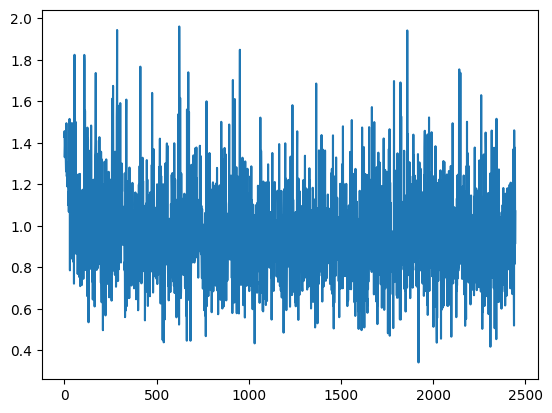

In [25]:
plt.plot(train_losses)

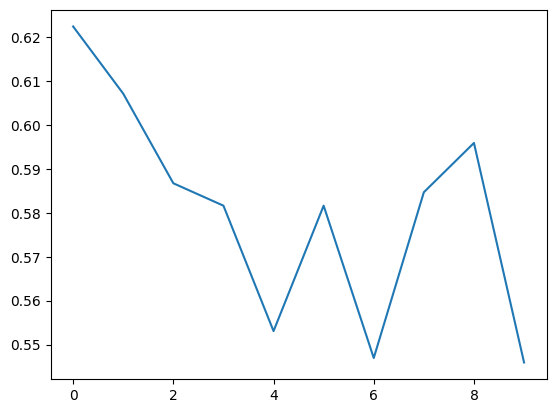

In [26]:
plt.plot(test_accuracy)

In [28]:
layer = model.fe_blocks.blocks[0].block.layer
named_params = [p for p in layer.named_parameters()]
named_params

[('lowcut_bands',
  Parameter containing:
  tensor([[ 0.0000],
          [-0.0250],
          [-0.0745],
          [ 0.1054],
          [-0.0382],
          [ 0.0072],
          [-0.0761],
          [-0.0680],
          [ 0.1465],
          [ 0.0251],
          [ 0.0686],
          [-0.0235],
          [-0.0121],
          [ 0.0351],
          [-0.1714],
          [ 0.1442],
          [ 0.1878],
          [-0.1853],
          [-0.0032],
          [ 0.2514],
          [ 0.1663],
          [ 0.2256],
          [ 0.0410],
          [ 0.2114],
          [-0.0625],
          [-0.1733],
          [ 0.1721],
          [ 0.1935],
          [ 0.0746],
          [ 0.1429],
          [-0.1168],
          [ 0.1622],
          [ 0.0372],
          [ 0.2041],
          [ 0.1175],
          [ 0.1434],
          [ 0.1664],
          [ 0.2870],
          [ 0.1683],
          [ 0.2584],
          [ 0.2141],
          [ 0.1481],
          [ 0.0122],
          [ 0.0821],
          [ 0.1582],
          [-0

In [29]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-4.9832e-03],
        [-3.6043e-02],
        [-1.6732e-02],
        [-2.4002e-02],
        [-4.7689e-02],
        [-7.0925e-03],
        [-1.7776e-02],
        [ 7.0612e-03],
        [-6.1921e-02],
        [ 1.4750e-02],
        [-1.7843e-02],
        [ 8.1307e-03],
        [-3.4469e-03],
        [-5.1872e-02],
        [-1.1774e-02],
        [-6.2262e-03],
        [ 7.2748e-03],
        [ 2.3949e-02],
        [-1.5437e-02],
        [ 6.5742e-04],
        [-3.0412e-02],
        [-2.2910e-03],
        [ 3.2197e-03],
        [-5.7168e-03],
        [-1.5069e-02],
        [-1.0764e-02],
        [-1.0586e-02],
        [ 2.4129e-02],
        [-3.3108e-03],
        [ 5.6621e-03],
        [ 1.4218e-03],
        [-3.9447e-02],
        [ 8.6649e-03],
        [-8.4132e-03],
        [ 7.6554e-04],
        [-2.7387e-02],
        [ 2.1432e-02],
        [-9.8812e-04],
        [-1.6479e-02],
        [-3.8202e-03],
        [ 1.3181e-03],
        [-9.1296e-03],
        [ 8

[None, None]

(array([ 3.,  0.,  0.,  4.,  0.,  6.,  3.,  6., 10.,  9.,  7.,  7.,  5.,
         5.,  9.,  5.,  7., 24.,  7.,  9.,  5., 12.,  3.,  4.,  4.,  4.,
         5.,  4.,  6.,  3.,  3.,  0.,  2.,  6.,  3.,  1.,  1.,  3.,  2.,
         1.]),
 array([-0.18533851, -0.16534698, -0.14535545, -0.12536392, -0.10537239,
        -0.08538086, -0.06538933, -0.0453978 , -0.02540627, -0.00541473,
         0.0145768 ,  0.03456833,  0.05455986,  0.07455139,  0.09454292,
         0.11453445,  0.13452598,  0.15451752,  0.17450905,  0.19450058,
         0.21449211,  0.23448363,  0.25447518,  0.27446669,  0.29445824,
         0.31444976,  0.3344413 ,  0.35443282,  0.37442434,  0.39441589,
         0.4144074 ,  0.43439895,  0.45439047,  0.47438201,  0.49437353,
         0.51436508,  0.53435659,  0.55434811,  0.57433969,  0.5943312 ,
         0.61432272]),
 <BarContainer object of 40 artists>)

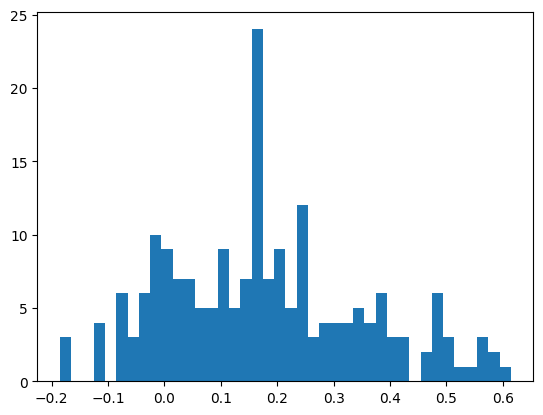

In [30]:
lowcut_bands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowcut_bands.flatten(), bins=40)

(array([ 2.,  2.,  4.,  3.,  5., 15., 29., 45., 40., 28., 10.,  6.,  4.,
         2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-7.26891682e-02, -6.36348948e-02, -5.45806251e-02, -4.55263518e-02,
        -3.64720821e-02, -2.74178088e-02, -1.83635373e-02, -9.30926669e-03,
        -2.54994637e-04,  8.79927725e-03,  1.78535488e-02,  2.69078203e-02,
         3.59620936e-02,  4.50163633e-02,  5.40706366e-02,  6.31249100e-02,
         7.21791759e-02,  8.12334493e-02,  9.02877226e-02,  9.93419960e-02,
         1.08396262e-01,  1.17450535e-01,  1.26504809e-01,  1.35559082e-01,
         1.44613355e-01,  1.53667629e-01,  1.62721902e-01,  1.71776161e-01,
         1.80830434e-01,  1.89884707e-01,  1.98938981e-01,  2.07993254e-01,
         2.17047527e-01,  2.26101801e-01,  2.35156074e-01,  2.44210348e-01,
         2.53264606e-01,  2.62318879e-01,  2.71373153e-01,  2.80427426e-01,
      

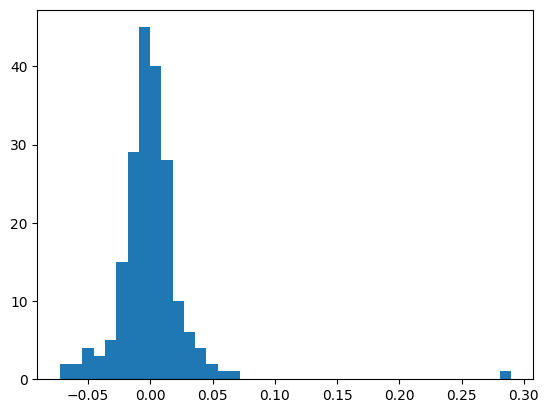

In [31]:
lowcut_bands_grad = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowcut_bands_grad.flatten(), bins=40)

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  6.,  3.,  4.,
        12.,  9.,  9.,  6.,  8.,  2.,  1.,  2.,  0.,  1.,  4., 10.,  7.,
         9., 15., 13., 10., 10., 16.,  6.,  7.,  4.,  3.,  3.,  4.,  2.,
         2.]),
 array([-0.28216639, -0.26905209, -0.25593778, -0.24282348, -0.22970918,
        -0.21659487, -0.20348059, -0.19036628, -0.17725198, -0.16413768,
        -0.15102337, -0.13790907, -0.12479477, -0.11168047, -0.09856617,
        -0.08545186, -0.07233756, -0.05922326, -0.04610896, -0.03299466,
        -0.01988035, -0.00676605,  0.00634825,  0.01946255,  0.03257685,
         0.04569115,  0.05880546,  0.07191976,  0.08503406,  0.09814836,
         0.11126266,  0.12437697,  0.13749127,  0.15060557,  0.16371988,
         0.17683417,  0.18994847,  0.20306277,  0.21617708,  0.22929138,
         0.24240568]),
 <BarContainer object of 40 artists>)

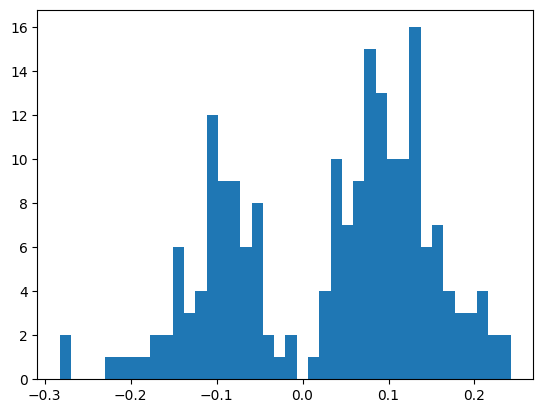

In [32]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  6.,  3.,  4.,
        12.,  9.,  9.,  6.,  8.,  2.,  1.,  2.,  0.,  1.,  4., 10.,  7.,
         9., 15., 13., 10., 10., 16.,  6.,  7.,  4.,  3.,  3.,  4.,  2.,
         2.]),
 array([-0.28216639, -0.26905209, -0.25593778, -0.24282348, -0.22970918,
        -0.21659487, -0.20348059, -0.19036628, -0.17725198, -0.16413768,
        -0.15102337, -0.13790907, -0.12479477, -0.11168047, -0.09856617,
        -0.08545186, -0.07233756, -0.05922326, -0.04610896, -0.03299466,
        -0.01988035, -0.00676605,  0.00634825,  0.01946255,  0.03257685,
         0.04569115,  0.05880546,  0.07191976,  0.08503406,  0.09814836,
         0.11126266,  0.12437697,  0.13749127,  0.15060557,  0.16371988,
         0.17683417,  0.18994847,  0.20306277,  0.21617708,  0.22929138,
         0.24240568]),
 <BarContainer object of 40 artists>)

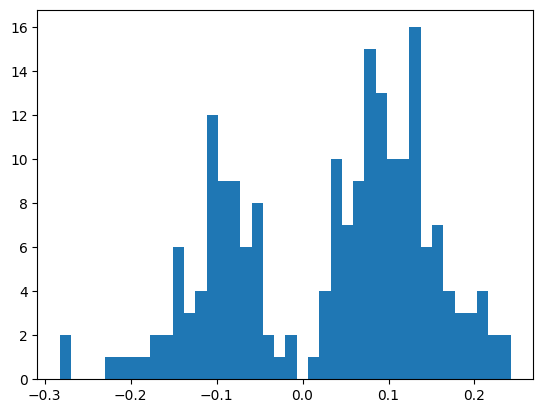

In [33]:
bandwidths_grad = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

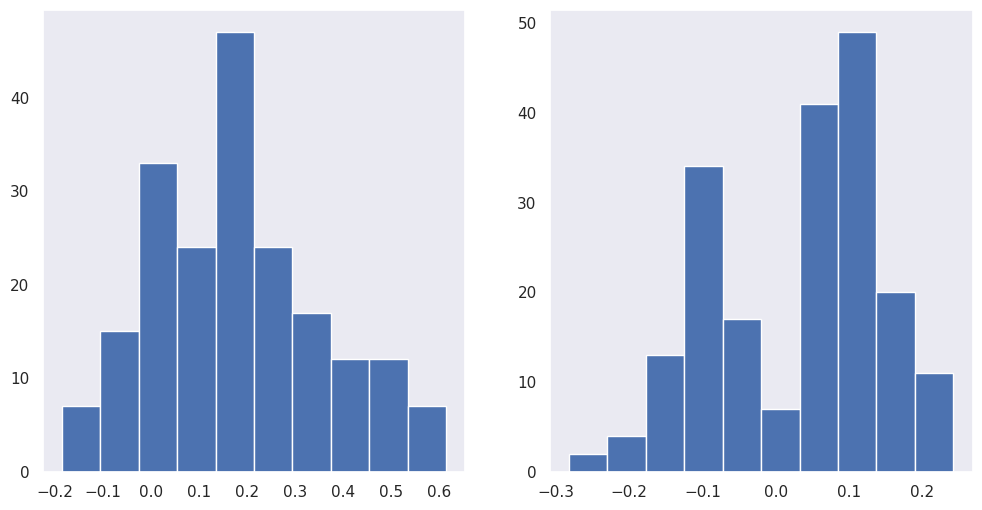

In [36]:
from IConNet.visualizer import visualize_model
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

(array([ 3.,  0.,  0.,  4.,  0.,  6.,  3.,  6., 10.,  9.,  7.,  7.,  5.,
         5.,  9.,  5.,  7., 24.,  7.,  9.,  5., 12.,  3.,  4.,  4.,  4.,
         5.,  4.,  6.,  3.,  3.,  0.,  2.,  6.,  3.,  1.,  1.,  3.,  2.,
         1.]),
 array([-0.18533851, -0.16534698, -0.14535545, -0.12536392, -0.10537239,
        -0.08538086, -0.06538933, -0.0453978 , -0.02540627, -0.00541473,
         0.0145768 ,  0.03456833,  0.05455986,  0.07455139,  0.09454292,
         0.11453445,  0.13452598,  0.15451752,  0.17450905,  0.19450058,
         0.21449211,  0.23448363,  0.25447518,  0.27446669,  0.29445824,
         0.31444976,  0.3344413 ,  0.35443282,  0.37442434,  0.39441589,
         0.4144074 ,  0.43439895,  0.45439047,  0.47438201,  0.49437353,
         0.51436508,  0.53435659,  0.55434811,  0.57433969,  0.5943312 ,
         0.61432272]),
 <BarContainer object of 40 artists>)

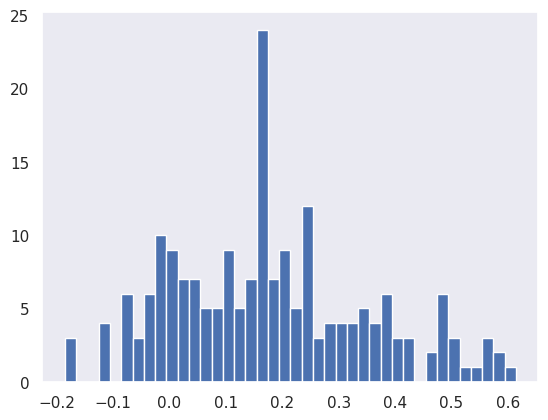

In [37]:
lowcut_bands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowcut_bands.flatten(), bins=40)

(array([ 2.,  2.,  4.,  3.,  5., 15., 29., 45., 40., 28., 10.,  6.,  4.,
         2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-7.26891682e-02, -6.36348948e-02, -5.45806251e-02, -4.55263518e-02,
        -3.64720821e-02, -2.74178088e-02, -1.83635373e-02, -9.30926669e-03,
        -2.54994637e-04,  8.79927725e-03,  1.78535488e-02,  2.69078203e-02,
         3.59620936e-02,  4.50163633e-02,  5.40706366e-02,  6.31249100e-02,
         7.21791759e-02,  8.12334493e-02,  9.02877226e-02,  9.93419960e-02,
         1.08396262e-01,  1.17450535e-01,  1.26504809e-01,  1.35559082e-01,
         1.44613355e-01,  1.53667629e-01,  1.62721902e-01,  1.71776161e-01,
         1.80830434e-01,  1.89884707e-01,  1.98938981e-01,  2.07993254e-01,
         2.17047527e-01,  2.26101801e-01,  2.35156074e-01,  2.44210348e-01,
         2.53264606e-01,  2.62318879e-01,  2.71373153e-01,  2.80427426e-01,
      

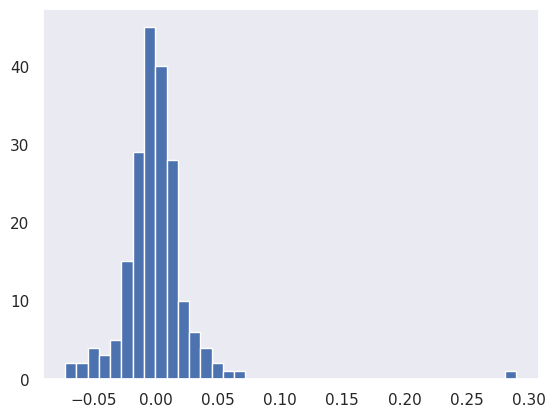

In [38]:
lowcut_bands_grad = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowcut_bands_grad.flatten(), bins=40)

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  6.,  3.,  4.,
        12.,  9.,  9.,  6.,  8.,  2.,  1.,  2.,  0.,  1.,  4., 10.,  7.,
         9., 15., 13., 10., 10., 16.,  6.,  7.,  4.,  3.,  3.,  4.,  2.,
         2.]),
 array([-0.28216639, -0.26905209, -0.25593778, -0.24282348, -0.22970918,
        -0.21659487, -0.20348059, -0.19036628, -0.17725198, -0.16413768,
        -0.15102337, -0.13790907, -0.12479477, -0.11168047, -0.09856617,
        -0.08545186, -0.07233756, -0.05922326, -0.04610896, -0.03299466,
        -0.01988035, -0.00676605,  0.00634825,  0.01946255,  0.03257685,
         0.04569115,  0.05880546,  0.07191976,  0.08503406,  0.09814836,
         0.11126266,  0.12437697,  0.13749127,  0.15060557,  0.16371988,
         0.17683417,  0.18994847,  0.20306277,  0.21617708,  0.22929138,
         0.24240568]),
 <BarContainer object of 40 artists>)

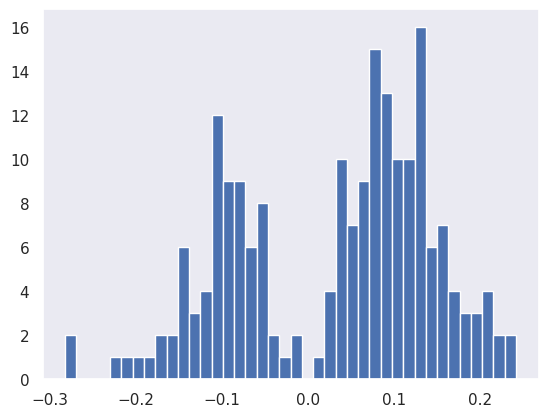

In [39]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 2.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  6.,  3.,  4.,
        12.,  9.,  9.,  6.,  8.,  2.,  1.,  2.,  0.,  1.,  4., 10.,  7.,
         9., 15., 13., 10., 10., 16.,  6.,  7.,  4.,  3.,  3.,  4.,  2.,
         2.]),
 array([-0.28216639, -0.26905209, -0.25593778, -0.24282348, -0.22970918,
        -0.21659487, -0.20348059, -0.19036628, -0.17725198, -0.16413768,
        -0.15102337, -0.13790907, -0.12479477, -0.11168047, -0.09856617,
        -0.08545186, -0.07233756, -0.05922326, -0.04610896, -0.03299466,
        -0.01988035, -0.00676605,  0.00634825,  0.01946255,  0.03257685,
         0.04569115,  0.05880546,  0.07191976,  0.08503406,  0.09814836,
         0.11126266,  0.12437697,  0.13749127,  0.15060557,  0.16371988,
         0.17683417,  0.18994847,  0.20306277,  0.21617708,  0.22929138,
         0.24240568]),
 <BarContainer object of 40 artists>)

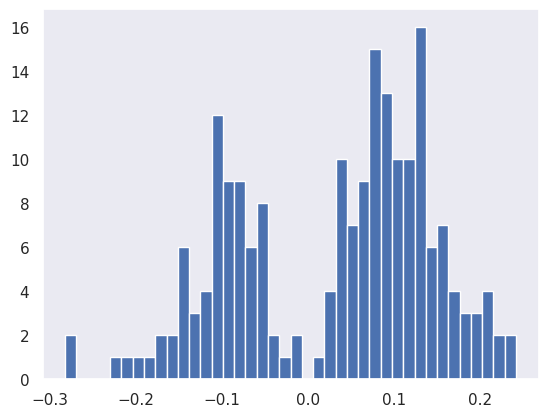

In [40]:
bandwidths_grad = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

In [44]:
layer.windows

tensor([0.0800, 0.0800, 0.0801, 0.0803, 0.0806, 0.0809, 0.0813, 0.0817, 0.0822,
        0.0828, 0.0835, 0.0842, 0.0850, 0.0859, 0.0868, 0.0878, 0.0889, 0.0900,
        0.0912, 0.0925, 0.0938, 0.0953, 0.0967, 0.0983, 0.0999, 0.1016, 0.1033,
        0.1051, 0.1070, 0.1089, 0.1109, 0.1130, 0.1152, 0.1174, 0.1196, 0.1219,
        0.1243, 0.1268, 0.1293, 0.1319, 0.1345, 0.1372, 0.1400, 0.1428, 0.1457,
        0.1486, 0.1516, 0.1547, 0.1578, 0.1610, 0.1642, 0.1675, 0.1709, 0.1743,
        0.1777, 0.1812, 0.1848, 0.1884, 0.1921, 0.1958, 0.1996, 0.2034, 0.2073,
        0.2113, 0.2152, 0.2193, 0.2233, 0.2275, 0.2316, 0.2359, 0.2401, 0.2444,
        0.2488, 0.2532, 0.2576, 0.2621, 0.2667, 0.2712, 0.2758, 0.2805, 0.2852,
        0.2899, 0.2947, 0.2995, 0.3043, 0.3092, 0.3141, 0.3190, 0.3240, 0.3290,
        0.3341, 0.3391, 0.3442, 0.3494, 0.3545, 0.3597, 0.3649, 0.3702, 0.3755,
        0.3808, 0.3861, 0.3914, 0.3968, 0.4022, 0.4076, 0.4130, 0.4184, 0.4239,
        0.4294, 0.4349, 0.4404, 0.4459, 

In [52]:
windows = torch.full_like(layer.lowcut_bands, 0.5).repeat(1,1,2)
windows.shape

torch.Size([1, 198, 2])

Time domain: Filters' shapes vary by frequency bins


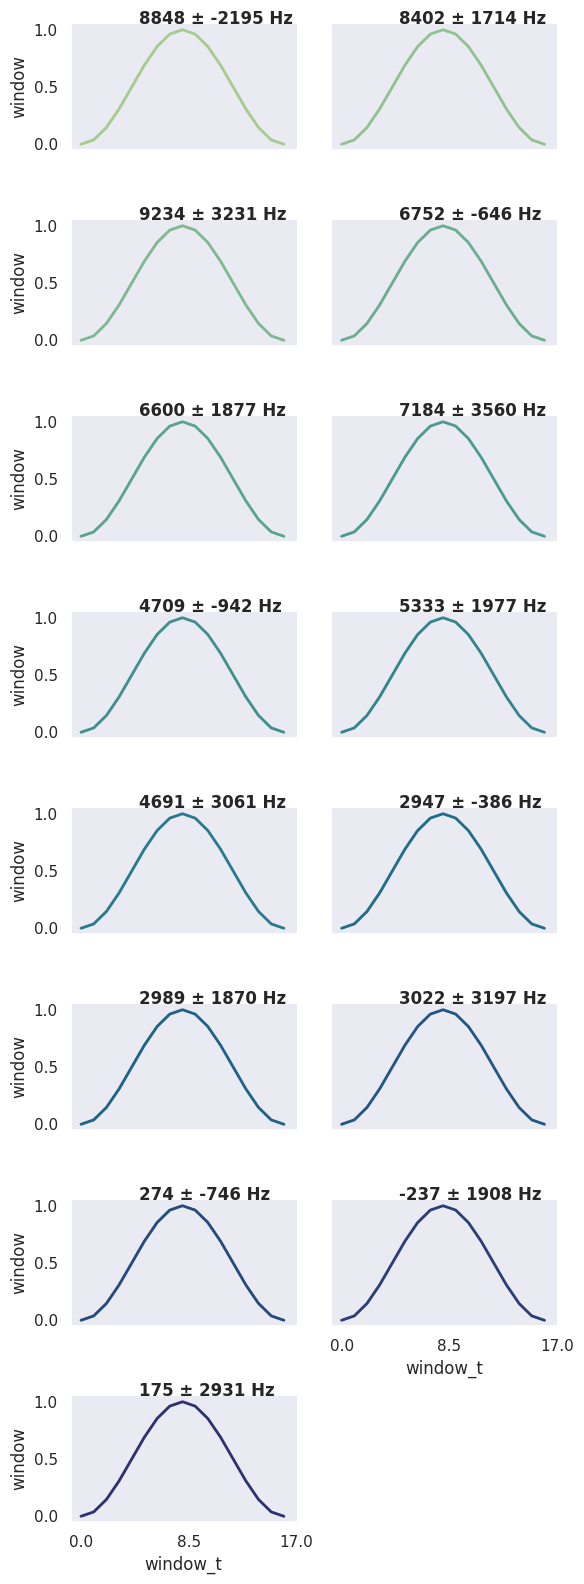

In [53]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = windows, 
    window_length = 64,
    sample_rate = sr
)

filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


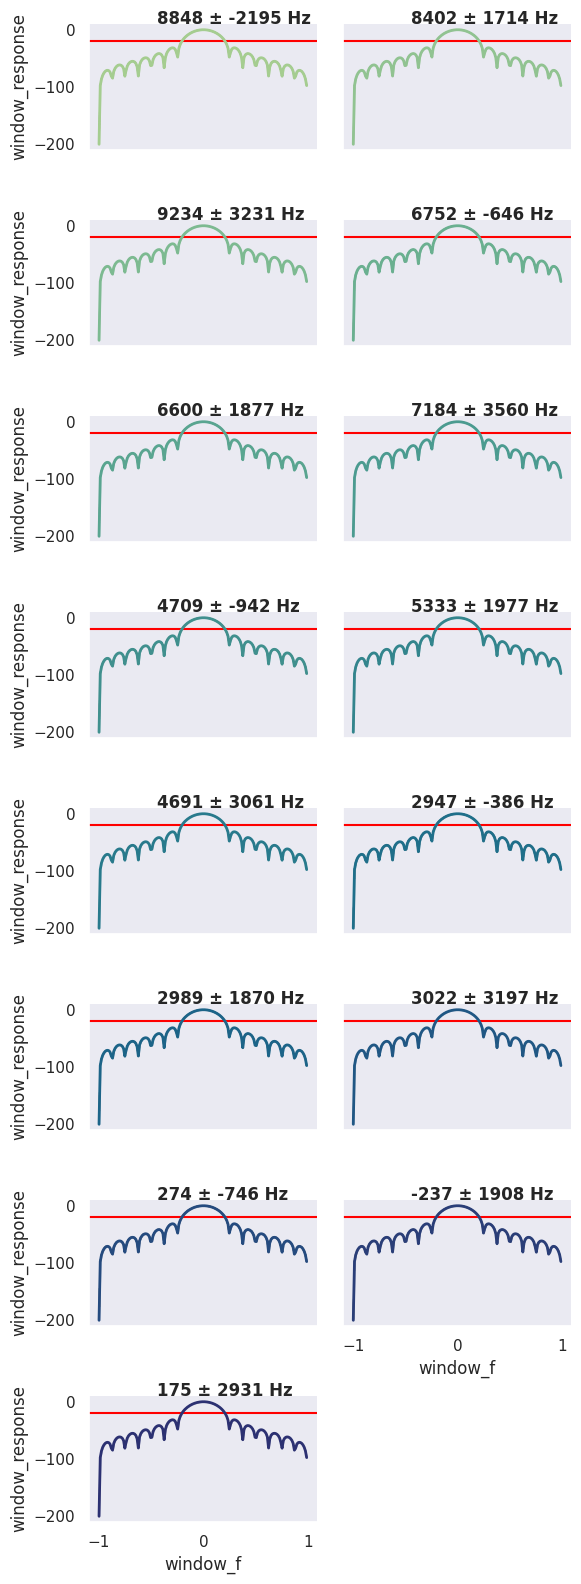

In [54]:
filtviz.visualize_filters(filter_domain='freq')

In [56]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [57]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 578/976 (0.5922)
{'acc_detail': tensor([0.5551, 0.4583, 0.7953, 0.5397], device='cuda:0'),
 'acc_unweighted': tensor(0.5871, device='cuda:0'),
 'acc_weighted': tensor(0.5922, device='cuda:0'),
 'f1s_detail': tensor([0.6845, 0.4583, 0.7113, 0.5037], device='cuda:0'),
 'f1s_unweighted': tensor(0.5894, device='cuda:0'),
 'f1s_weighted': tensor(0.5947, device='cuda:0'),
 'precision_detail': tensor([0.8924, 0.4583, 0.6433, 0.4722], device='cuda:0'),
 'recall_detail': tensor([0.5551, 0.4583, 0.7953, 0.5397], device='cuda:0'),
 'rocauc': tensor(0.8348, device='cuda:0'),
 'rocauc_detail': tensor([0.9189, 0.8040, 0.9014, 0.7150], device='cuda:0'),
 'uar': tensor(0.5871, device='cuda:0'),
 'wap': tensor(0.6230, device='cuda:0')}


tensor([[141,  13,   5,  95],
        [  0,  99,  74,  43],
        [  2,  36, 202,  14],
        [ 15,  68,  33, 136]], device='cuda:0')

In [58]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m14sinc_improved_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/50 [00:00<2:28:07, 177.77s/it]

Train Epoch: 11 [0/3918 (0%)]	Loss: 0.940482
Mem before-during-after: 652176384 4603518464 655350784


  0%|                                | 0.13442622950819672/50 [00:25<2:47:08, 201.11s/it]

Train Epoch: 11 [640/3918 (16%)]	Loss: 0.718002
Mem before-during-after: 655350784 4604719616 655350784


  1%|▏                               | 0.26557377049180286/50 [00:50<2:39:50, 192.84s/it]

Train Epoch: 11 [1280/3918 (33%)]	Loss: 1.076632
Mem before-during-after: 655350784 4606816768 655350784


  1%|▎                                  | 0.39672131147541/50 [01:15<2:38:36, 191.85s/it]

Train Epoch: 11 [1920/3918 (49%)]	Loss: 0.753539
Mem before-during-after: 655350784 4604719616 655350784


  1%|▎                                | 0.5278688524590167/50 [01:41<2:46:02, 201.38s/it]

Train Epoch: 11 [2560/3918 (66%)]	Loss: 0.908960
Mem before-during-after: 655350784 4604719616 655350784


  1%|▍                                | 0.6590163934426216/50 [02:06<2:39:18, 193.72s/it]

Train Epoch: 11 [3200/3918 (82%)]	Loss: 0.873541
Mem before-during-after: 655350784 4604719616 655350784


  2%|▌                                | 0.7901639344262266/50 [02:30<2:31:32, 184.77s/it]

Train Epoch: 11 [3840/3918 (98%)]	Loss: 1.101712
Mem before-during-after: 655350784 4578728448 655350784


  2%|▋                                 | 0.9999999999999944/50 [02:48<1:04:51, 79.41s/it]


Test Epoch: 11	Accuracy: 593/976 (61%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_11epoch.pt


  2%|▋                                | 1.0032786885245846/50 [02:49<1:29:59, 110.20s/it]

Train Epoch: 12 [0/3918 (0%)]	Loss: 0.869836
Mem before-during-after: 655349760 4606691840 655350784


  2%|▋                                | 1.1344262295081895/50 [03:14<2:38:42, 194.87s/it]

Train Epoch: 12 [640/3918 (16%)]	Loss: 1.034150
Mem before-during-after: 655350784 4604719616 655350784


  3%|▊                                | 1.2655737704917944/50 [03:39<2:32:14, 187.43s/it]

Train Epoch: 12 [1280/3918 (33%)]	Loss: 1.062984
Mem before-during-after: 655350784 4604719616 655350784


  3%|▉                                | 1.3967213114753994/50 [04:04<2:31:34, 187.13s/it]

Train Epoch: 12 [1920/3918 (49%)]	Loss: 0.698837
Mem before-during-after: 655350784 4604719616 655350784


  3%|█                                | 1.5278688524590043/50 [04:27<2:30:17, 186.03s/it]

Train Epoch: 12 [2560/3918 (66%)]	Loss: 0.903935
Mem before-during-after: 655350784 4604719616 655350784


  3%|█                                | 1.6590163934426092/50 [04:51<2:22:15, 176.57s/it]

Train Epoch: 12 [3200/3918 (82%)]	Loss: 1.358694
Mem before-during-after: 655350784 4547430400 655350784


  4%|█▏                               | 1.7901639344262141/50 [05:15<2:28:41, 185.05s/it]

Train Epoch: 12 [3840/3918 (98%)]	Loss: 0.796082
Mem before-during-after: 655350784 4604719616 655350784


  4%|█▍                                 | 1.999999999999982/50 [05:33<1:04:21, 80.44s/it]


Test Epoch: 12	Accuracy: 590/976 (60%)



  4%|█▎                               | 2.0032786885245724/50 [05:34<1:21:52, 102.35s/it]

Train Epoch: 13 [0/3918 (0%)]	Loss: 0.793317
Mem before-during-after: 655349760 4441417216 655350784


  4%|█▍                               | 2.1344262295081773/50 [05:58<2:27:45, 185.21s/it]

Train Epoch: 13 [640/3918 (16%)]	Loss: 0.901562
Mem before-during-after: 655350784 4606816768 655350784


  5%|█▌                                | 2.265573770491782/50 [06:22<2:27:53, 185.90s/it]

Train Epoch: 13 [1280/3918 (33%)]	Loss: 0.803296
Mem before-during-after: 655350784 4604719616 655350784


  5%|█▋                                | 2.396721311475387/50 [06:46<2:32:40, 192.44s/it]

Train Epoch: 13 [1920/3918 (49%)]	Loss: 1.022948
Mem before-during-after: 655350784 4604719616 655350784


  5%|█▋                                | 2.527868852458992/50 [07:11<2:30:58, 190.82s/it]

Train Epoch: 13 [2560/3918 (66%)]	Loss: 1.055242
Mem before-during-after: 655350784 4604719616 655350784


  5%|█▊                                | 2.659016393442597/50 [07:36<2:30:07, 190.27s/it]

Train Epoch: 13 [3200/3918 (82%)]	Loss: 1.073629
Mem before-during-after: 655350784 4604719616 655350784


  6%|█▉                                | 2.790163934426202/50 [08:00<2:25:42, 185.18s/it]

Train Epoch: 13 [3840/3918 (98%)]	Loss: 0.698792
Mem before-during-after: 655350784 4358919680 655350784


  6%|██▏                                 | 2.99999999999997/50 [08:18<1:03:04, 80.51s/it]


Test Epoch: 13	Accuracy: 588/976 (60%)



  6%|██                                 | 3.00327868852456/50 [08:19<1:25:26, 109.09s/it]

Train Epoch: 14 [0/3918 (0%)]	Loss: 1.012756
Mem before-during-after: 655349760 4606691840 655350784


  6%|██▏                               | 3.134426229508165/50 [08:44<2:32:33, 195.31s/it]

Train Epoch: 14 [640/3918 (16%)]	Loss: 0.907664
Mem before-during-after: 655350784 4604719616 655350784


  7%|██▎                                | 3.26557377049177/50 [09:08<2:19:28, 179.07s/it]

Train Epoch: 14 [1280/3918 (33%)]	Loss: 0.666210
Mem before-during-after: 655350784 4606816768 655350784


  7%|██▏                              | 3.3967213114753747/50 [09:34<2:30:34, 193.86s/it]

Train Epoch: 14 [1920/3918 (49%)]	Loss: 0.730234
Mem before-during-after: 655350784 4604719616 655350784


  7%|██▎                              | 3.5278688524589796/50 [09:58<2:23:56, 185.85s/it]

Train Epoch: 14 [2560/3918 (66%)]	Loss: 0.778366
Mem before-during-after: 655350784 4604719616 655350784


  7%|██▍                              | 3.6590163934425846/50 [10:22<2:20:46, 182.28s/it]

Train Epoch: 14 [3200/3918 (82%)]	Loss: 0.811872
Mem before-during-after: 655350784 4604719616 655350784


  8%|██▌                              | 3.7901639344261895/50 [10:47<2:21:40, 183.95s/it]

Train Epoch: 14 [3840/3918 (98%)]	Loss: 0.964012
Mem before-during-after: 655350784 4604719616 655350784


  8%|██▉                                 | 3.9999999999999574/50 [11:05<59:53, 78.12s/it]


Test Epoch: 14	Accuracy: 588/976 (60%)



  8%|██▋                              | 4.0032786885245475/50 [11:05<1:21:31, 106.34s/it]

Train Epoch: 15 [0/3918 (0%)]	Loss: 0.636399
Mem before-during-after: 655349760 4606691840 655350784


  8%|██▊                               | 4.134426229508152/50 [11:29<2:18:34, 181.28s/it]

Train Epoch: 15 [640/3918 (16%)]	Loss: 0.847538
Mem before-during-after: 655350784 4604719616 655350784


  9%|██▉                               | 4.265573770491757/50 [11:53<2:19:32, 183.07s/it]

Train Epoch: 15 [1280/3918 (33%)]	Loss: 0.966583
Mem before-during-after: 655350784 4604719616 655350784


  9%|██▉                               | 4.396721311475362/50 [12:17<2:16:57, 180.20s/it]

Train Epoch: 15 [1920/3918 (49%)]	Loss: 1.044021
Mem before-during-after: 655350784 4441089024 655350784


  9%|███                               | 4.527868852458967/50 [12:40<2:16:59, 180.76s/it]

Train Epoch: 15 [2560/3918 (66%)]	Loss: 0.910132
Mem before-during-after: 655350784 4604719616 655350784


  9%|███▏                              | 4.659016393442572/50 [13:04<2:16:11, 180.23s/it]

Train Epoch: 15 [3200/3918 (82%)]	Loss: 0.863256
Mem before-during-after: 655350784 4604719616 655350784


 10%|███▎                              | 4.790163934426177/50 [13:28<2:17:22, 182.32s/it]

Train Epoch: 15 [3840/3918 (98%)]	Loss: 0.417974
Mem before-during-after: 655350784 4604719616 655350784


 10%|███▋                                 | 4.999999999999945/50 [13:45<58:04, 77.44s/it]


Test Epoch: 15	Accuracy: 603/976 (62%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_15epoch.pt


 10%|███▍                              | 5.003278688524535/50 [13:46<1:20:21, 107.15s/it]

Train Epoch: 16 [0/3918 (0%)]	Loss: 0.759202
Mem before-during-after: 655349760 4606691840 655350784


 10%|███▌                               | 5.13442622950814/50 [14:09<2:14:51, 180.35s/it]

Train Epoch: 16 [640/3918 (16%)]	Loss: 0.882780
Mem before-during-after: 655350784 4604719616 655350784


 11%|███▌                              | 5.265573770491745/50 [14:33<2:11:16, 176.08s/it]

Train Epoch: 16 [1280/3918 (33%)]	Loss: 1.204834
Mem before-during-after: 655350784 4604719616 655350784


 11%|███▊                               | 5.39672131147535/50 [14:57<2:15:44, 182.59s/it]

Train Epoch: 16 [1920/3918 (49%)]	Loss: 0.661164
Mem before-during-after: 655350784 4604719616 655350784


 11%|███▊                              | 5.527868852458955/50 [15:20<2:14:47, 181.86s/it]

Train Epoch: 16 [2560/3918 (66%)]	Loss: 0.815229
Mem before-during-after: 655350784 4604719616 655350784


 11%|███▉                               | 5.65901639344256/50 [15:44<2:14:49, 182.43s/it]

Train Epoch: 16 [3200/3918 (82%)]	Loss: 0.804392
Mem before-during-after: 655350784 4604719616 655350784


 12%|███▉                              | 5.790163934426165/50 [16:08<2:11:14, 178.12s/it]

Train Epoch: 16 [3840/3918 (98%)]	Loss: 0.636848
Mem before-during-after: 655350784 4358919680 655350784


 12%|████▎                               | 5.9999999999999325/50 [16:25<56:28, 77.01s/it]


Test Epoch: 16	Accuracy: 592/976 (60%)



 12%|████                              | 6.003278688524523/50 [16:26<1:17:49, 106.13s/it]

Train Epoch: 17 [0/3918 (0%)]	Loss: 0.587969
Mem before-during-after: 655349760 4606691840 655350784


 12%|████                             | 6.1344262295081275/50 [16:50<2:13:55, 183.18s/it]

Train Epoch: 17 [640/3918 (16%)]	Loss: 0.804731
Mem before-during-after: 655350784 4604719616 655350784


 13%|████▏                            | 6.2655737704917325/50 [17:14<2:13:44, 183.48s/it]

Train Epoch: 17 [1280/3918 (33%)]	Loss: 0.900240
Mem before-during-after: 655350784 4604719616 655350784


 13%|████▎                             | 6.396721311475337/50 [17:37<2:12:03, 181.72s/it]

Train Epoch: 17 [1920/3918 (49%)]	Loss: 0.740770
Mem before-during-after: 655350784 4604719616 655350784


 13%|████▍                             | 6.527868852458942/50 [18:01<2:10:42, 180.39s/it]

Train Epoch: 17 [2560/3918 (66%)]	Loss: 0.608267
Mem before-during-after: 655350784 4604719616 655350784


 13%|████▌                             | 6.659016393442547/50 [18:24<2:13:14, 184.45s/it]

Train Epoch: 17 [3200/3918 (82%)]	Loss: 1.110213
Mem before-during-after: 655350784 4604719616 655350784


 14%|████▌                             | 6.790163934426152/50 [18:48<2:11:37, 182.78s/it]

Train Epoch: 17 [3840/3918 (98%)]	Loss: 0.992770
Mem before-during-after: 655350784 4604719616 655350784


 14%|█████▎                                | 6.99999999999992/50 [19:05<55:51, 77.95s/it]


Test Epoch: 17	Accuracy: 604/976 (62%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_17epoch.pt


 14%|████▉                              | 7.00327868852451/50 [19:06<1:18:20, 109.31s/it]

Train Epoch: 18 [0/3918 (0%)]	Loss: 0.805130
Mem before-during-after: 655349760 4606691840 655350784


 14%|████▊                             | 7.134426229508115/50 [19:29<2:05:41, 175.93s/it]

Train Epoch: 18 [640/3918 (16%)]	Loss: 1.025388
Mem before-during-after: 655350784 4604719616 655350784


 15%|█████                              | 7.26557377049172/50 [19:53<2:09:00, 181.12s/it]

Train Epoch: 18 [1280/3918 (33%)]	Loss: 0.779285
Mem before-during-after: 655350784 4604719616 655350784


 15%|█████                             | 7.396721311475325/50 [20:16<2:08:10, 180.51s/it]

Train Epoch: 18 [1920/3918 (49%)]	Loss: 1.085724
Mem before-during-after: 655350784 4604719616 655350784


 15%|█████▎                             | 7.52786885245893/50 [20:40<2:09:13, 182.56s/it]

Train Epoch: 18 [2560/3918 (66%)]	Loss: 0.570744
Mem before-during-after: 655350784 4604719616 655350784


 15%|█████▏                            | 7.659016393442535/50 [21:04<2:06:43, 179.57s/it]

Train Epoch: 18 [3200/3918 (82%)]	Loss: 0.809279
Mem before-during-after: 655350784 4441089024 655350784


 16%|█████▍                             | 7.79016393442614/50 [21:28<2:09:27, 184.02s/it]

Train Epoch: 18 [3840/3918 (98%)]	Loss: 0.905560
Mem before-during-after: 655350784 4604719616 655350784


 16%|█████▉                               | 7.999999999999908/50 [21:45<54:03, 77.23s/it]


Test Epoch: 18	Accuracy: 605/976 (62%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_18epoch.pt


 16%|█████▍                            | 8.003278688524498/50 [21:46<1:15:53, 108.43s/it]

Train Epoch: 19 [0/3918 (0%)]	Loss: 0.826958
Mem before-during-after: 655349760 4606691840 655350784


 16%|█████▌                            | 8.134426229508103/50 [22:09<2:07:29, 182.71s/it]

Train Epoch: 19 [640/3918 (16%)]	Loss: 0.632167
Mem before-during-after: 655350784 4604719616 655350784


 17%|█████▌                            | 8.265573770491708/50 [22:33<2:05:12, 180.00s/it]

Train Epoch: 19 [1280/3918 (33%)]	Loss: 0.927452
Mem before-during-after: 655350784 4604719616 655350784


 17%|█████▋                            | 8.396721311475313/50 [22:57<2:06:15, 182.09s/it]

Train Epoch: 19 [1920/3918 (49%)]	Loss: 0.693025
Mem before-during-after: 655350784 4604719616 655350784


 17%|█████▊                            | 8.527868852458917/50 [23:20<2:01:00, 175.07s/it]

Train Epoch: 19 [2560/3918 (66%)]	Loss: 0.841904
Mem before-during-after: 655350784 4547430400 655350784


 17%|█████▉                            | 8.659016393442522/50 [23:44<2:05:15, 181.79s/it]

Train Epoch: 19 [3200/3918 (82%)]	Loss: 0.740996
Mem before-during-after: 655350784 4604719616 655350784


 18%|█████▉                            | 8.790163934426127/50 [24:08<2:04:46, 181.66s/it]

Train Epoch: 19 [3840/3918 (98%)]	Loss: 1.123463
Mem before-during-after: 655350784 4604719616 655350784


 18%|██████▋                              | 8.999999999999895/50 [24:25<53:00, 77.58s/it]


Test Epoch: 19	Accuracy: 600/976 (61%)



 18%|██████▎                            | 9.003278688524485/50 [24:26<1:02:37, 91.65s/it]

Train Epoch: 20 [0/3918 (0%)]	Loss: 0.784709
Mem before-during-after: 655349760 4359513088 655350784


 18%|██████▍                            | 9.13442622950809/50 [24:49<2:04:29, 182.78s/it]

Train Epoch: 20 [640/3918 (16%)]	Loss: 0.684567
Mem before-during-after: 655350784 4604719616 655350784


 19%|██████▎                           | 9.265573770491695/50 [25:13<2:03:20, 181.69s/it]

Train Epoch: 20 [1280/3918 (33%)]	Loss: 0.561916
Mem before-during-after: 655350784 4604719616 655350784


 19%|██████▊                             | 9.3967213114753/50 [25:36<2:01:41, 179.82s/it]

Train Epoch: 20 [1920/3918 (49%)]	Loss: 0.577659
Mem before-during-after: 655350784 4604719616 655350784


 19%|██████▍                           | 9.527868852458905/50 [26:00<2:04:24, 184.43s/it]

Train Epoch: 20 [2560/3918 (66%)]	Loss: 0.768435
Mem before-during-after: 655350784 4604719616 655350784


 19%|██████▊                            | 9.65901639344251/50 [26:24<2:02:25, 182.09s/it]

Train Epoch: 20 [3200/3918 (82%)]	Loss: 0.932342
Mem before-during-after: 655350784 4604719616 655350784


 20%|██████▋                           | 9.790163934426115/50 [26:48<2:01:19, 181.04s/it]

Train Epoch: 20 [3840/3918 (98%)]	Loss: 0.961058
Mem before-during-after: 655350784 4604719616 655350784


 20%|███████▍                             | 9.999999999999883/50 [27:05<52:10, 78.27s/it]


Test Epoch: 20	Accuracy: 593/976 (61%)



 20%|██████▌                          | 10.003278688524473/50 [27:06<1:11:05, 106.65s/it]

Train Epoch: 21 [0/3918 (0%)]	Loss: 0.638716
Mem before-during-after: 655349760 4606691840 655350784


 20%|██████▋                          | 10.134426229508078/50 [27:30<2:01:54, 183.48s/it]

Train Epoch: 21 [640/3918 (16%)]	Loss: 0.520393
Mem before-during-after: 655350784 4604719616 655350784


 21%|██████▊                          | 10.265573770491683/50 [27:53<2:00:21, 181.73s/it]

Train Epoch: 21 [1280/3918 (33%)]	Loss: 1.245717
Mem before-during-after: 655350784 4604719616 655350784


 21%|██████▊                          | 10.396721311475288/50 [28:17<2:00:44, 182.93s/it]

Train Epoch: 21 [1920/3918 (49%)]	Loss: 0.847533
Mem before-during-after: 655350784 4606816768 655350784


 21%|██████▉                          | 10.527868852458893/50 [28:40<1:58:01, 179.41s/it]

Train Epoch: 21 [2560/3918 (66%)]	Loss: 1.003924
Mem before-during-after: 655350784 4604719616 655350784


 21%|███████                          | 10.659016393442498/50 [29:04<1:58:40, 181.00s/it]

Train Epoch: 21 [3200/3918 (82%)]	Loss: 0.843239
Mem before-during-after: 655350784 4604719616 655350784


 22%|███████                          | 10.790163934426102/50 [29:28<1:58:02, 180.63s/it]

Train Epoch: 21 [3840/3918 (98%)]	Loss: 0.992650
Mem before-during-after: 655350784 4604719616 655350784


 22%|████████▏                            | 10.99999999999987/50 [29:45<48:56, 75.30s/it]


Test Epoch: 21	Accuracy: 594/976 (61%)



 22%|███████▍                          | 11.00327868852446/50 [29:46<1:08:09, 104.87s/it]

Train Epoch: 22 [0/3918 (0%)]	Loss: 1.000896
Mem before-during-after: 655349760 4606691840 655350784


 22%|███████▎                         | 11.134426229508065/50 [30:09<1:57:18, 181.11s/it]

Train Epoch: 22 [640/3918 (16%)]	Loss: 0.848096
Mem before-during-after: 655350784 4604719616 655350784


 23%|███████▋                          | 11.26557377049167/50 [30:33<1:56:46, 180.89s/it]

Train Epoch: 22 [1280/3918 (33%)]	Loss: 0.646732
Mem before-during-after: 655350784 4441089024 655350784


 23%|███████▌                         | 11.396721311475275/50 [30:57<1:57:40, 182.90s/it]

Train Epoch: 22 [1920/3918 (49%)]	Loss: 1.216488
Mem before-during-after: 655350784 4604719616 655350784


 23%|███████▊                          | 11.52786885245888/50 [31:20<1:55:15, 179.76s/it]

Train Epoch: 22 [2560/3918 (66%)]	Loss: 0.818761
Mem before-during-after: 655350784 4604719616 655350784


 23%|███████▋                         | 11.659016393442485/50 [31:44<1:57:12, 183.43s/it]

Train Epoch: 22 [3200/3918 (82%)]	Loss: 0.940634
Mem before-during-after: 655350784 4604719616 655350784


 24%|████████                          | 11.79016393442609/50 [32:08<1:56:44, 183.32s/it]

Train Epoch: 22 [3840/3918 (98%)]	Loss: 1.159351
Mem before-during-after: 655350784 4604719616 655350784


 24%|████████▋                           | 11.999999999999858/50 [32:25<48:57, 77.30s/it]


Test Epoch: 22	Accuracy: 602/976 (61%)



 24%|███████▉                         | 12.003278688524448/50 [32:26<1:07:41, 106.90s/it]

Train Epoch: 23 [0/3918 (0%)]	Loss: 0.813365
Mem before-during-after: 655349760 4606692352 655350784


 24%|████████                         | 12.134426229508053/50 [32:49<1:52:59, 179.05s/it]

Train Epoch: 23 [640/3918 (16%)]	Loss: 0.886685
Mem before-during-after: 655350784 4604719616 655350784


 25%|████████                         | 12.265573770491658/50 [33:13<1:53:53, 181.09s/it]

Train Epoch: 23 [1280/3918 (33%)]	Loss: 0.693800
Mem before-during-after: 655350784 4604719616 655350784


 25%|████████▏                        | 12.396721311475263/50 [33:37<2:03:22, 196.85s/it]

Train Epoch: 23 [1920/3918 (49%)]	Loss: 0.682754
Mem before-during-after: 655350784 4604719616 655350784


 25%|████████▎                        | 12.527868852458868/50 [34:02<1:56:36, 186.70s/it]

Train Epoch: 23 [2560/3918 (66%)]	Loss: 0.852545
Mem before-during-after: 655350784 4604719616 655350784


 25%|████████▎                        | 12.659016393442473/50 [34:26<1:56:30, 187.20s/it]

Train Epoch: 23 [3200/3918 (82%)]	Loss: 0.930537
Mem before-during-after: 655350784 4604719616 655350784


 26%|████████▍                        | 12.790163934426078/50 [34:50<1:52:21, 181.17s/it]

Train Epoch: 23 [3840/3918 (98%)]	Loss: 0.849196
Mem before-during-after: 655350784 4604719616 655350784


 26%|█████████▎                          | 12.999999999999845/50 [35:08<47:36, 77.20s/it]


Test Epoch: 23	Accuracy: 599/976 (61%)



 26%|████████▌                        | 13.003278688524436/50 [35:08<1:04:54, 105.27s/it]

Train Epoch: 24 [0/3918 (0%)]	Loss: 0.637332
Mem before-during-after: 655349760 4606692352 655350784


 26%|████████▉                         | 13.13442622950804/50 [35:32<1:52:04, 182.41s/it]

Train Epoch: 24 [640/3918 (16%)]	Loss: 1.138514
Mem before-during-after: 655350784 4604719616 655350784


 27%|████████▊                        | 13.265573770491645/50 [35:55<1:51:41, 182.42s/it]

Train Epoch: 24 [1280/3918 (33%)]	Loss: 0.687504
Mem before-during-after: 655350784 4604719616 655350784


 27%|█████████                         | 13.39672131147525/50 [36:19<1:50:46, 181.59s/it]

Train Epoch: 24 [1920/3918 (49%)]	Loss: 0.592406
Mem before-during-after: 655350784 4604719616 655350784


 27%|████████▉                        | 13.527868852458855/50 [36:43<1:51:02, 182.68s/it]

Train Epoch: 24 [2560/3918 (66%)]	Loss: 1.055243
Mem before-during-after: 655350784 4604719616 655350784


 27%|█████████▎                        | 13.65901639344246/50 [37:06<1:40:43, 166.30s/it]

Train Epoch: 24 [3200/3918 (82%)]	Loss: 1.006009
Mem before-during-after: 655350784 4536944640 655350784


 28%|█████████                        | 13.790163934426065/50 [37:30<1:51:48, 185.25s/it]

Train Epoch: 24 [3840/3918 (98%)]	Loss: 0.678805
Mem before-during-after: 655350784 4604719616 655350784


 28%|██████████                          | 13.999999999999833/50 [37:48<47:02, 78.41s/it]


Test Epoch: 24	Accuracy: 611/976 (62%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_24epoch.pt


 28%|█████████▏                       | 14.003278688524423/50 [37:48<1:00:03, 100.11s/it]

Train Epoch: 25 [0/3918 (0%)]	Loss: 1.022271
Mem before-during-after: 655349760 4524424704 655350784


 28%|█████████▎                       | 14.134426229508028/50 [38:13<1:54:15, 191.14s/it]

Train Epoch: 25 [640/3918 (16%)]	Loss: 0.877211
Mem before-during-after: 655350784 4604719616 655350784


 29%|█████████▍                       | 14.265573770491633/50 [38:38<1:54:59, 193.09s/it]

Train Epoch: 25 [1280/3918 (33%)]	Loss: 0.673930
Mem before-during-after: 655350784 4604719616 655350784


 29%|█████████▌                       | 14.396721311475238/50 [39:03<1:48:51, 183.45s/it]

Train Epoch: 25 [1920/3918 (49%)]	Loss: 0.870354
Mem before-during-after: 655350784 4520257536 655350784


 29%|█████████▌                       | 14.527868852458843/50 [39:28<1:49:36, 185.41s/it]

Train Epoch: 25 [2560/3918 (66%)]	Loss: 0.963602
Mem before-during-after: 655350784 4547430400 655350784


 29%|█████████▋                       | 14.659016393442448/50 [39:53<1:53:50, 193.27s/it]

Train Epoch: 25 [3200/3918 (82%)]	Loss: 0.837883
Mem before-during-after: 655350784 4604719616 655350784


 30%|█████████▊                       | 14.790163934426053/50 [40:19<1:54:02, 194.32s/it]

Train Epoch: 25 [3840/3918 (98%)]	Loss: 1.101651
Mem before-during-after: 655350784 4604719616 655350784


 30%|███████████                          | 14.99999999999982/50 [40:37<45:25, 77.87s/it]


Test Epoch: 25	Accuracy: 607/976 (62%)



 30%|██████████▏                       | 15.00327868852441/50 [40:38<1:03:02, 108.09s/it]

Train Epoch: 26 [0/3918 (0%)]	Loss: 0.964334
Mem before-during-after: 655349760 4606691840 655350784


 30%|█████████▉                       | 15.134426229508016/50 [41:03<1:49:12, 187.94s/it]

Train Epoch: 26 [640/3918 (16%)]	Loss: 0.975341
Mem before-during-after: 655350784 4604719616 655350784


 31%|██████████▍                       | 15.26557377049162/50 [41:28<1:50:28, 190.82s/it]

Train Epoch: 26 [1280/3918 (33%)]	Loss: 0.993445
Mem before-during-after: 655350784 4604719616 655350784


 31%|██████████▏                      | 15.396721311475225/50 [41:53<1:47:35, 186.55s/it]

Train Epoch: 26 [1920/3918 (49%)]	Loss: 0.914359
Mem before-during-after: 655350784 4604719616 655350784


 31%|██████████▌                       | 15.52786885245883/50 [42:18<1:50:11, 191.79s/it]

Train Epoch: 26 [2560/3918 (66%)]	Loss: 0.627385
Mem before-during-after: 655350784 4604719616 655350784


 31%|██████████▎                      | 15.659016393442435/50 [42:43<1:50:42, 193.41s/it]

Train Epoch: 26 [3200/3918 (82%)]	Loss: 1.250454
Mem before-during-after: 655350784 4568242688 655350784


 32%|██████████▋                       | 15.79016393442604/50 [43:08<1:48:41, 190.63s/it]

Train Epoch: 26 [3840/3918 (98%)]	Loss: 1.325977
Mem before-during-after: 655350784 4604719616 655350784


 32%|███████████▌                        | 15.999999999999808/50 [43:26<43:32, 76.85s/it]


Test Epoch: 26	Accuracy: 608/976 (62%)



 32%|███████████▏                       | 16.0032786885244/50 [43:26<1:01:00, 107.68s/it]

Train Epoch: 27 [0/3918 (0%)]	Loss: 0.996812
Mem before-during-after: 655349760 4606691840 655350784


 32%|██████████▋                      | 16.134426229508076/50 [43:51<1:49:56, 194.78s/it]

Train Epoch: 27 [640/3918 (16%)]	Loss: 0.735180
Mem before-during-after: 655350784 4604719616 655350784


 33%|██████████▋                      | 16.265573770491752/50 [44:16<1:49:20, 194.48s/it]

Train Epoch: 27 [1280/3918 (33%)]	Loss: 0.788673
Mem before-during-after: 655350784 4604719616 655350784


 33%|██████████▊                      | 16.396721311475428/50 [44:41<1:48:00, 192.87s/it]

Train Epoch: 27 [1920/3918 (49%)]	Loss: 0.844892
Mem before-during-after: 655350784 4604719616 655350784


 33%|██████████▉                      | 16.527868852459104/50 [45:07<1:47:11, 192.15s/it]

Train Epoch: 27 [2560/3918 (66%)]	Loss: 1.213378
Mem before-during-after: 655350784 4604719616 655350784


 33%|███████████▎                      | 16.65901639344278/50 [45:32<1:43:43, 186.66s/it]

Train Epoch: 27 [3200/3918 (82%)]	Loss: 0.682873
Mem before-during-after: 655350784 4520257536 655350784


 34%|███████████                      | 16.790163934426456/50 [45:57<1:44:57, 189.64s/it]

Train Epoch: 27 [3840/3918 (98%)]	Loss: 0.902407
Mem before-during-after: 655350784 4185967104 655350784


 34%|████████████▏                       | 17.000000000000338/50 [46:15<41:39, 75.75s/it]


Test Epoch: 27	Accuracy: 610/976 (62%)



 34%|████████████▌                        | 17.00327868852493/50 [46:15<54:55, 99.87s/it]

Train Epoch: 28 [0/3918 (0%)]	Loss: 0.466408
Mem before-during-after: 655349760 4524424704 655350784


 34%|███████████▎                     | 17.134426229508605/50 [46:40<1:45:45, 193.08s/it]

Train Epoch: 28 [640/3918 (16%)]	Loss: 0.717841
Mem before-during-after: 655350784 4604719616 655350784


 35%|███████████▋                      | 17.26557377049228/50 [47:05<1:45:58, 194.23s/it]

Train Epoch: 28 [1280/3918 (33%)]	Loss: 0.942031
Mem before-during-after: 655350784 4604719616 655350784


 35%|███████████▍                     | 17.396721311475957/50 [47:30<1:49:32, 201.58s/it]

Train Epoch: 28 [1920/3918 (49%)]	Loss: 1.198612
Mem before-during-after: 655350784 4604719616 655350784


 35%|███████████▌                     | 17.527868852459633/50 [47:56<1:45:15, 194.50s/it]

Train Epoch: 28 [2560/3918 (66%)]	Loss: 0.773187
Mem before-during-after: 655350784 4604719616 655350784


 35%|████████████                      | 17.65901639344331/50 [48:21<1:45:09, 195.10s/it]

Train Epoch: 28 [3200/3918 (82%)]	Loss: 0.825785
Mem before-during-after: 655350784 4604719616 655350784


 36%|███████████▋                     | 17.790163934426985/50 [48:45<1:42:41, 191.28s/it]

Train Epoch: 28 [3840/3918 (98%)]	Loss: 1.011441
Mem before-during-after: 655350784 4604719616 655350784


 36%|████████████▉                       | 18.000000000000867/50 [49:03<41:53, 78.53s/it]


Test Epoch: 28	Accuracy: 625/976 (64%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_28epoch.pt


 36%|████████████▉                       | 18.00327868852546/50 [49:04<58:16, 109.29s/it]

Train Epoch: 29 [0/3918 (0%)]	Loss: 0.750748
Mem before-during-after: 655349760 4606691840 655350784


 36%|███████████▉                     | 18.134426229509135/50 [49:29<1:42:53, 193.73s/it]

Train Epoch: 29 [640/3918 (16%)]	Loss: 0.695981
Mem before-during-after: 655350784 4604719616 655350784


 37%|████████████▍                     | 18.26557377049281/50 [49:54<1:39:29, 188.09s/it]

Train Epoch: 29 [1280/3918 (33%)]	Loss: 0.973137
Mem before-during-after: 655350784 4604719616 655350784


 37%|████████████▏                    | 18.396721311476487/50 [50:19<1:41:09, 192.05s/it]

Train Epoch: 29 [1920/3918 (49%)]	Loss: 0.584966
Mem before-during-after: 655350784 4604719616 655350784


 37%|████████████▏                    | 18.527868852460163/50 [50:44<1:40:53, 192.35s/it]

Train Epoch: 29 [2560/3918 (66%)]	Loss: 0.862866
Mem before-during-after: 655350784 4604719616 655350784


 37%|████████████▋                     | 18.65901639344384/50 [51:10<1:39:56, 191.34s/it]

Train Epoch: 29 [3200/3918 (82%)]	Loss: 0.573498
Mem before-during-after: 655350784 4604719616 655350784


 38%|████████████▍                    | 18.790163934427515/50 [51:35<1:40:31, 193.26s/it]

Train Epoch: 29 [3840/3918 (98%)]	Loss: 0.759657
Mem before-during-after: 655350784 4604719616 655350784


 38%|█████████████▋                      | 19.000000000001396/50 [51:52<40:09, 77.71s/it]


Test Epoch: 29	Accuracy: 619/976 (63%)



 38%|█████████████▎                     | 19.003278688525988/50 [51:53<55:45, 107.92s/it]

Train Epoch: 30 [0/3918 (0%)]	Loss: 0.792809
Mem before-during-after: 655349760 4606691840 655350784


 38%|████████████▋                    | 19.134426229509664/50 [52:18<1:38:43, 191.91s/it]

Train Epoch: 30 [640/3918 (16%)]	Loss: 0.900156
Mem before-during-after: 655350784 4604719616 655350784


 39%|█████████████                     | 19.26557377049334/50 [52:43<1:38:27, 192.23s/it]

Train Epoch: 30 [1280/3918 (33%)]	Loss: 0.610803
Mem before-during-after: 655350784 4604719616 655350784


 39%|████████████▊                    | 19.396721311477016/50 [53:08<1:37:35, 191.33s/it]

Train Epoch: 30 [1920/3918 (49%)]	Loss: 1.083432
Mem before-during-after: 655350784 4604719616 655350784


 39%|████████████▉                    | 19.527868852460692/50 [53:33<1:37:43, 192.42s/it]

Train Epoch: 30 [2560/3918 (66%)]	Loss: 0.631548
Mem before-during-after: 655350784 4604719616 655350784


 39%|████████████▉                    | 19.659016393444368/50 [53:58<1:38:15, 194.30s/it]

Train Epoch: 30 [3200/3918 (82%)]	Loss: 0.913534
Mem before-during-after: 655350784 4604719616 655350784


 40%|█████████████                    | 19.790163934428044/50 [54:23<1:34:37, 187.93s/it]

Train Epoch: 30 [3840/3918 (98%)]	Loss: 0.929477
Mem before-during-after: 655350784 4604719616 655350784


 40%|██████████████▍                     | 20.000000000001926/50 [54:42<38:50, 77.68s/it]


Test Epoch: 30	Accuracy: 615/976 (63%)



 40%|██████████████                     | 20.003278688526517/50 [54:42<54:13, 108.45s/it]

Train Epoch: 31 [0/3918 (0%)]	Loss: 0.770318
Mem before-during-after: 655349760 4606691840 655350784


 40%|█████████████▎                   | 20.134426229510193/50 [55:07<1:35:48, 192.47s/it]

Train Epoch: 31 [640/3918 (16%)]	Loss: 0.843232
Mem before-during-after: 655350784 4604719616 655350784


 41%|█████████████▊                    | 20.26557377049387/50 [55:32<1:34:46, 191.24s/it]

Train Epoch: 31 [1280/3918 (33%)]	Loss: 0.605222
Mem before-during-after: 655350784 4604719616 655350784


 41%|█████████████▍                   | 20.396721311477545/50 [55:57<1:36:08, 194.85s/it]

Train Epoch: 31 [1920/3918 (49%)]	Loss: 0.745745
Mem before-during-after: 655350784 4604719616 655350784


 41%|█████████████▉                    | 20.52786885246122/50 [56:22<1:33:54, 191.19s/it]

Train Epoch: 31 [2560/3918 (66%)]	Loss: 0.941144
Mem before-during-after: 655350784 4604719616 655475712


 41%|█████████████▋                   | 20.659016393444897/50 [56:47<1:34:45, 193.76s/it]

Train Epoch: 31 [3200/3918 (82%)]	Loss: 0.850192
Mem before-during-after: 655350784 4604719616 655350784


 42%|█████████████▋                   | 20.790163934428573/50 [57:13<1:32:44, 190.49s/it]

Train Epoch: 31 [3840/3918 (98%)]	Loss: 0.776087
Mem before-during-after: 655350784 4606816768 655350784


 42%|███████████████                     | 21.000000000002455/50 [57:30<37:51, 78.33s/it]


Test Epoch: 31	Accuracy: 630/976 (64%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_31epoch.pt


 42%|██████████████▋                    | 21.003278688527047/50 [57:31<52:47, 109.23s/it]

Train Epoch: 32 [0/3918 (0%)]	Loss: 0.718636
Mem before-during-after: 655349760 4606691840 655350784


 42%|█████████████▉                   | 21.134426229510723/50 [57:56<1:30:30, 188.12s/it]

Train Epoch: 32 [640/3918 (16%)]	Loss: 0.742334
Mem before-during-after: 655350784 4606816768 655350784


 43%|██████████████▉                    | 21.2655737704944/50 [58:21<1:31:04, 190.16s/it]

Train Epoch: 32 [1280/3918 (33%)]	Loss: 0.777318
Mem before-during-after: 655350784 4604719616 655350784


 43%|██████████████                   | 21.396721311478075/50 [58:46<1:29:19, 187.37s/it]

Train Epoch: 32 [1920/3918 (49%)]	Loss: 1.169959
Mem before-during-after: 655350784 4604719616 655350784


 43%|██████████████▋                   | 21.52786885246175/50 [59:10<1:28:14, 185.96s/it]

Train Epoch: 32 [2560/3918 (66%)]	Loss: 0.833994
Mem before-during-after: 655350784 4604719616 655350784


 43%|██████████████▎                  | 21.659016393445427/50 [59:35<1:28:18, 186.94s/it]

Train Epoch: 32 [3200/3918 (82%)]	Loss: 0.646157
Mem before-during-after: 655350784 4604719616 655350784


 44%|██████████████▍                  | 21.790163934429103/50 [59:59<1:26:52, 184.77s/it]

Train Epoch: 32 [3840/3918 (98%)]	Loss: 0.868185
Mem before-during-after: 655350784 4604719616 655350784


 44%|██████████████▉                   | 22.000000000002984/50 [1:00:16<36:57, 79.20s/it]


Test Epoch: 32	Accuracy: 614/976 (63%)



 44%|██████████████▌                  | 22.003278688527576/50 [1:00:17<49:56, 107.03s/it]

Train Epoch: 33 [0/3918 (0%)]	Loss: 0.858427
Mem before-during-after: 655349760 4606691840 655350784


 44%|█████████████▋                 | 22.134426229511252/50 [1:00:41<1:23:06, 178.96s/it]

Train Epoch: 33 [640/3918 (16%)]	Loss: 0.769181
Mem before-during-after: 655350784 4604719616 655350784


 45%|█████████████▊                 | 22.265573770494928/50 [1:01:05<1:27:27, 189.21s/it]

Train Epoch: 33 [1280/3918 (33%)]	Loss: 0.955081
Mem before-during-after: 655350784 4604719616 655350784


 45%|█████████████▉                 | 22.396721311478604/50 [1:01:29<1:22:12, 178.69s/it]

Train Epoch: 33 [1920/3918 (49%)]	Loss: 0.827003
Mem before-during-after: 655350784 4606816768 655350784


 45%|██████████████▍                 | 22.52786885246228/50 [1:01:53<1:23:06, 181.51s/it]

Train Epoch: 33 [2560/3918 (66%)]	Loss: 0.948368
Mem before-during-after: 655350784 4604719616 655350784


 45%|██████████████                 | 22.659016393445956/50 [1:02:16<1:23:09, 182.49s/it]

Train Epoch: 33 [3200/3918 (82%)]	Loss: 0.839353
Mem before-during-after: 655350784 4604719616 655350784


 46%|██████████████▏                | 22.790163934429632/50 [1:02:40<1:22:51, 182.72s/it]

Train Epoch: 33 [3840/3918 (98%)]	Loss: 0.842594
Mem before-during-after: 655350784 4604719616 655350784


 46%|███████████████▋                  | 23.000000000003514/50 [1:02:58<34:45, 77.26s/it]


Test Epoch: 33	Accuracy: 617/976 (63%)



 46%|███████████████▏                 | 23.003278688528106/50 [1:02:58<47:09, 104.80s/it]

Train Epoch: 34 [0/3918 (0%)]	Loss: 0.856818
Mem before-during-after: 655349760 4606691840 655350784


 46%|██████████████▊                 | 23.13442622951178/50 [1:03:23<1:28:00, 196.55s/it]

Train Epoch: 34 [640/3918 (16%)]	Loss: 0.849899
Mem before-during-after: 655350784 4604719616 655350784


 47%|██████████████▍                | 23.265573770495457/50 [1:03:48<1:25:01, 190.81s/it]

Train Epoch: 34 [1280/3918 (33%)]	Loss: 0.505784
Mem before-during-after: 655350784 4604719616 655350784


 47%|██████████████▌                | 23.396721311479133/50 [1:04:14<1:24:39, 190.92s/it]

Train Epoch: 34 [1920/3918 (49%)]	Loss: 0.741439
Mem before-during-after: 655350784 4604719616 655350784


 47%|███████████████                 | 23.52786885246281/50 [1:04:38<1:24:17, 191.05s/it]

Train Epoch: 34 [2560/3918 (66%)]	Loss: 0.603163
Mem before-during-after: 655350784 4604719616 655350784


 47%|██████████████▋                | 23.659016393446485/50 [1:05:03<1:19:46, 181.72s/it]

Train Epoch: 34 [3200/3918 (82%)]	Loss: 0.893187
Mem before-during-after: 655350784 4520257536 655350784


 48%|███████████████▏                | 23.79016393443016/50 [1:05:28<1:27:50, 201.11s/it]

Train Epoch: 34 [3840/3918 (98%)]	Loss: 0.660947
Mem before-during-after: 655350784 4606816768 655350784


 48%|████████████████▎                 | 24.000000000004043/50 [1:05:46<33:55, 78.29s/it]


Test Epoch: 34	Accuracy: 610/976 (62%)



 48%|███████████████▊                 | 24.003278688528635/50 [1:05:47<46:00, 106.20s/it]

Train Epoch: 35 [0/3918 (0%)]	Loss: 0.954063
Mem before-during-after: 655349760 4606692352 655350784


 48%|███████████████▍                | 24.13442622951231/50 [1:06:12<1:23:19, 193.29s/it]

Train Epoch: 35 [640/3918 (16%)]	Loss: 0.768398
Mem before-during-after: 655350784 4604719616 655350784


 49%|███████████████                | 24.265573770495987/50 [1:06:37<1:24:24, 196.78s/it]

Train Epoch: 35 [1280/3918 (33%)]	Loss: 0.904821
Mem before-during-after: 655350784 4604719616 655350784


 49%|███████████████▏               | 24.396721311479663/50 [1:07:03<1:22:26, 193.18s/it]

Train Epoch: 35 [1920/3918 (49%)]	Loss: 1.272949
Mem before-during-after: 655350784 4604719616 655350784


 49%|███████████████▋                | 24.52786885246334/50 [1:07:27<1:20:40, 190.02s/it]

Train Epoch: 35 [2560/3918 (66%)]	Loss: 0.828514
Mem before-during-after: 655350784 4604719616 655350784


 49%|███████████████▎               | 24.659016393447015/50 [1:07:52<1:20:46, 191.25s/it]

Train Epoch: 35 [3200/3918 (82%)]	Loss: 0.754773
Mem before-during-after: 655350784 4441089024 655350784


 50%|███████████████▊                | 24.79016393443069/50 [1:08:18<1:27:25, 208.06s/it]

Train Epoch: 35 [3840/3918 (98%)]	Loss: 0.957128
Mem before-during-after: 655350784 4604719616 655350784


 50%|█████████████████                 | 25.000000000004572/50 [1:08:36<33:19, 79.99s/it]


Test Epoch: 35	Accuracy: 626/976 (64%)



 50%|████████████████▌                | 25.003278688529164/50 [1:08:36<45:52, 110.12s/it]

Train Epoch: 36 [0/3918 (0%)]	Loss: 1.054229
Mem before-during-after: 655349760 4606691840 655350784


 50%|████████████████                | 25.13442622951284/50 [1:09:01<1:19:47, 192.54s/it]

Train Epoch: 36 [640/3918 (16%)]	Loss: 0.778175
Mem before-during-after: 655350784 4604719616 655350784


 51%|███████████████▋               | 25.265573770496516/50 [1:09:26<1:20:30, 195.31s/it]

Train Epoch: 36 [1280/3918 (33%)]	Loss: 0.891013
Mem before-during-after: 655350784 4604719616 655350784


 51%|███████████████▋               | 25.396721311480192/50 [1:09:51<1:19:44, 194.46s/it]

Train Epoch: 36 [1920/3918 (49%)]	Loss: 0.777107
Mem before-during-after: 655350784 4604719616 655350784


 51%|███████████████▊               | 25.527868852463868/50 [1:10:16<1:18:32, 192.56s/it]

Train Epoch: 36 [2560/3918 (66%)]	Loss: 0.868692
Mem before-during-after: 655350784 4604719616 655350784


 51%|███████████████▉               | 25.659016393447544/50 [1:10:41<1:15:15, 185.52s/it]

Train Epoch: 36 [3200/3918 (82%)]	Loss: 0.727472
Mem before-during-after: 655350784 4547430400 655350784


 52%|████████████████▌               | 25.79016393443122/50 [1:11:07<1:20:12, 198.77s/it]

Train Epoch: 36 [3840/3918 (98%)]	Loss: 0.666174
Mem before-during-after: 655350784 4604719616 655350784


 52%|██████████████████▋                 | 26.0000000000051/50 [1:11:25<30:48, 77.03s/it]


Test Epoch: 36	Accuracy: 589/976 (60%)



 52%|█████████████████▏               | 26.003278688529694/50 [1:11:26<44:59, 112.48s/it]

Train Epoch: 37 [0/3918 (0%)]	Loss: 1.038041
Mem before-during-after: 655349760 4606692352 655350784


 52%|████████████████▋               | 26.13442622951337/50 [1:11:50<1:14:13, 186.61s/it]

Train Epoch: 37 [640/3918 (16%)]	Loss: 0.772746
Mem before-during-after: 655350784 4604719616 655350784


 53%|████████████████▎              | 26.265573770497046/50 [1:12:14<1:12:26, 183.12s/it]

Train Epoch: 37 [1280/3918 (33%)]	Loss: 0.708707
Mem before-during-after: 655350784 4358919680 655350784


 53%|████████████████▉               | 26.39672131148072/50 [1:12:39<1:16:07, 193.51s/it]

Train Epoch: 37 [1920/3918 (49%)]	Loss: 0.885369
Mem before-during-after: 655350784 4604719616 655350784


 53%|████████████████▍              | 26.527868852464398/50 [1:13:03<1:12:38, 185.67s/it]

Train Epoch: 37 [2560/3918 (66%)]	Loss: 0.839696
Mem before-during-after: 655350784 4604719616 655350784


 53%|████████████████▌              | 26.659016393448074/50 [1:13:27<1:11:08, 182.86s/it]

Train Epoch: 37 [3200/3918 (82%)]	Loss: 0.441643
Mem before-during-after: 655350784 4604719616 655350784


 54%|█████████████████▏              | 26.79016393443175/50 [1:13:50<1:10:17, 181.73s/it]

Train Epoch: 37 [3840/3918 (98%)]	Loss: 0.949922
Mem before-during-after: 655350784 4604719616 655350784


 54%|██████████████████▉                | 27.00000000000563/50 [1:14:07<29:25, 76.78s/it]


Test Epoch: 37	Accuracy: 611/976 (62%)



 54%|█████████████████▊               | 27.003278688530223/50 [1:14:08<40:01, 104.42s/it]

Train Epoch: 38 [0/3918 (0%)]	Loss: 1.059131
Mem before-during-after: 655349760 4606692352 655350784


 54%|█████████████████▉               | 27.1344262295139/50 [1:14:32<1:11:16, 187.03s/it]

Train Epoch: 38 [640/3918 (16%)]	Loss: 0.562828
Mem before-during-after: 655350784 4604719616 655350784


 55%|████████████████▉              | 27.265573770497575/50 [1:14:56<1:09:50, 184.32s/it]

Train Epoch: 38 [1280/3918 (33%)]	Loss: 1.475928
Mem before-during-after: 655350784 4604719616 655350784


 55%|█████████████████▌              | 27.39672131148125/50 [1:15:21<1:11:49, 190.66s/it]

Train Epoch: 38 [1920/3918 (49%)]	Loss: 0.784177
Mem before-during-after: 655350784 4604719616 655350784


 55%|█████████████████              | 27.527868852464927/50 [1:15:46<1:12:21, 193.22s/it]

Train Epoch: 38 [2560/3918 (66%)]	Loss: 0.803043
Mem before-during-after: 655350784 4604719616 655350784


 55%|█████████████████▏             | 27.659016393448603/50 [1:16:11<1:13:35, 197.62s/it]

Train Epoch: 38 [3200/3918 (82%)]	Loss: 0.587232
Mem before-during-after: 655350784 4604719616 655350784


 56%|█████████████████▊              | 27.79016393443228/50 [1:16:37<1:08:29, 185.03s/it]

Train Epoch: 38 [3840/3918 (98%)]	Loss: 0.937046
Mem before-during-after: 655350784 4547430400 655350784


 56%|███████████████████▌               | 28.00000000000616/50 [1:16:54<28:01, 76.45s/it]


Test Epoch: 38	Accuracy: 639/976 (65%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_38epoch.pt


 56%|██████████████████▍              | 28.003278688530752/50 [1:16:55<39:14, 107.03s/it]

Train Epoch: 39 [0/3918 (0%)]	Loss: 0.723335
Mem before-during-after: 655349760 4606691840 655350784


 56%|██████████████████              | 28.13442622951443/50 [1:17:20<1:10:17, 192.89s/it]

Train Epoch: 39 [640/3918 (16%)]	Loss: 1.109747
Mem before-during-after: 655350784 4604719616 655350784


 57%|█████████████████▌             | 28.265573770498104/50 [1:17:45<1:09:36, 192.18s/it]

Train Epoch: 39 [1280/3918 (33%)]	Loss: 0.930004
Mem before-during-after: 655350784 4604719616 655350784


 57%|██████████████████▏             | 28.39672131148178/50 [1:18:10<1:10:06, 194.70s/it]

Train Epoch: 39 [1920/3918 (49%)]	Loss: 0.939449
Mem before-during-after: 655350784 4604719616 655350784


 57%|█████████████████▋             | 28.527868852465456/50 [1:18:35<1:09:05, 193.06s/it]

Train Epoch: 39 [2560/3918 (66%)]	Loss: 0.706169
Mem before-during-after: 655350784 4604719616 655350784


 57%|█████████████████▊             | 28.659016393449132/50 [1:19:01<1:07:44, 190.44s/it]

Train Epoch: 39 [3200/3918 (82%)]	Loss: 0.570753
Mem before-during-after: 655350784 4604719616 655350784


 58%|█████████████████▊             | 28.790163934432808/50 [1:19:26<1:06:53, 189.23s/it]

Train Epoch: 39 [3840/3918 (98%)]	Loss: 1.182930
Mem before-during-after: 655350784 4604719616 655350784


 58%|████████████████████▎              | 29.00000000000669/50 [1:19:44<27:07, 77.52s/it]


Test Epoch: 39	Accuracy: 587/976 (60%)



 58%|███████████████████▋              | 29.00327868853128/50 [1:19:44<38:53, 111.15s/it]

Train Epoch: 40 [0/3918 (0%)]	Loss: 1.547575
Mem before-during-after: 655349760 4606691840 655350784


 58%|██████████████████             | 29.134426229514958/50 [1:20:09<1:04:37, 185.81s/it]

Train Epoch: 40 [640/3918 (16%)]	Loss: 0.808996
Mem before-during-after: 655350784 4520257536 655350784


 59%|██████████████████▏            | 29.265573770498634/50 [1:20:35<1:07:08, 194.28s/it]

Train Epoch: 40 [1280/3918 (33%)]	Loss: 0.841552
Mem before-during-after: 655350784 4604719616 655350784


 59%|██████████████████▊             | 29.39672131148231/50 [1:21:00<1:05:49, 191.70s/it]

Train Epoch: 40 [1920/3918 (49%)]	Loss: 0.629864
Mem before-during-after: 655350784 4604719616 655350784


 59%|██████████████████▎            | 29.527868852465986/50 [1:21:25<1:06:13, 194.09s/it]

Train Epoch: 40 [2560/3918 (66%)]	Loss: 0.648276
Mem before-during-after: 655350784 4604719616 655350784


 59%|██████████████████▉             | 29.65901639344966/50 [1:21:51<1:11:11, 209.97s/it]

Train Epoch: 40 [3200/3918 (82%)]	Loss: 0.972294
Mem before-during-after: 655350784 4604719616 655350784


 60%|██████████████████▍            | 29.790163934433338/50 [1:22:16<1:03:37, 188.90s/it]

Train Epoch: 40 [3840/3918 (98%)]	Loss: 0.838542
Mem before-during-after: 655350784 4604719616 655350784


 60%|█████████████████████              | 30.00000000000722/50 [1:22:34<26:23, 79.15s/it]


Test Epoch: 40	Accuracy: 620/976 (63%)



 60%|████████████████████▍             | 30.00327868853181/50 [1:22:35<36:27, 109.39s/it]

Train Epoch: 41 [0/3918 (0%)]	Loss: 1.158912
Mem before-during-after: 655349760 4606692352 655350784


 60%|██████████████████▋            | 30.134426229515487/50 [1:23:00<1:01:52, 186.90s/it]

Train Epoch: 41 [640/3918 (16%)]	Loss: 0.702109
Mem before-during-after: 655350784 4604719616 655350784


 61%|██████████████████▊            | 30.265573770499163/50 [1:23:24<1:00:22, 183.57s/it]

Train Epoch: 41 [1280/3918 (33%)]	Loss: 1.383795
Mem before-during-after: 655350784 4604719616 655350784


 61%|████████████████████▋             | 30.39672131148284/50 [1:23:48<58:40, 179.57s/it]

Train Epoch: 41 [1920/3918 (49%)]	Loss: 0.878401
Mem before-during-after: 655350784 4606816768 655350784


 61%|██████████████████▉            | 30.527868852466515/50 [1:24:12<1:00:20, 185.91s/it]

Train Epoch: 41 [2560/3918 (66%)]	Loss: 1.176729
Mem before-during-after: 655350784 4604719616 655350784


 61%|████████████████████▊             | 30.65901639345019/50 [1:24:36<59:26, 184.42s/it]

Train Epoch: 41 [3200/3918 (82%)]	Loss: 0.805457
Mem before-during-after: 655350784 4604719616 655350784


 62%|███████████████████            | 30.790163934433867/50 [1:25:01<1:01:00, 190.56s/it]

Train Epoch: 41 [3840/3918 (98%)]	Loss: 0.681721
Mem before-during-after: 655350784 4604719616 655350784


 62%|█████████████████████▋             | 31.00000000000775/50 [1:25:19<24:49, 78.40s/it]


Test Epoch: 41	Accuracy: 619/976 (63%)



 62%|█████████████████████             | 31.00327868853234/50 [1:25:19<33:21, 105.35s/it]

Train Epoch: 42 [0/3918 (0%)]	Loss: 0.931215
Mem before-during-after: 655349760 4606691840 655350784


 62%|████████████████████▌            | 31.134426229516016/50 [1:25:44<58:33, 186.26s/it]

Train Epoch: 42 [640/3918 (16%)]	Loss: 0.697740
Mem before-during-after: 655350784 4604719616 655350784


 63%|████████████████████▋            | 31.265573770499692/50 [1:26:08<58:46, 188.25s/it]

Train Epoch: 42 [1280/3918 (33%)]	Loss: 0.736711
Mem before-during-after: 655350784 4604719616 655350784


 63%|█████████████████████▎            | 31.39672131148337/50 [1:26:32<57:32, 185.60s/it]

Train Epoch: 42 [1920/3918 (49%)]	Loss: 0.575783
Mem before-during-after: 655350784 4604719616 655350784


 63%|████████████████████▊            | 31.527868852467044/50 [1:26:56<57:12, 185.83s/it]

Train Epoch: 42 [2560/3918 (66%)]	Loss: 0.916643
Mem before-during-after: 655350784 4604719616 655350784


 63%|█████████████████████▌            | 31.65901639345072/50 [1:27:20<55:45, 182.43s/it]

Train Epoch: 42 [3200/3918 (82%)]	Loss: 1.140549
Mem before-during-after: 655350784 4604719616 655350784


 64%|████████████████████▉            | 31.790163934434396/50 [1:27:45<55:08, 181.71s/it]

Train Epoch: 42 [3840/3918 (98%)]	Loss: 0.773566
Mem before-during-after: 655350784 4604719616 655350784


 64%|██████████████████████▍            | 32.00000000000828/50 [1:28:02<22:44, 75.78s/it]


Test Epoch: 42	Accuracy: 617/976 (63%)



 64%|█████████████████████            | 32.003278688532866/50 [1:28:03<31:24, 104.72s/it]

Train Epoch: 43 [0/3918 (0%)]	Loss: 1.070484
Mem before-during-after: 655349760 4606691840 655350784


 64%|██████████████████████▍            | 32.1344262295164/50 [1:28:27<54:23, 182.66s/it]

Train Epoch: 43 [640/3918 (16%)]	Loss: 0.855424
Mem before-during-after: 655350784 4604719616 655350784


 65%|█████████████████████▎           | 32.265573770499934/50 [1:28:50<53:32, 181.12s/it]

Train Epoch: 43 [1280/3918 (33%)]	Loss: 0.727423
Mem before-during-after: 655350784 4604719616 655350784


 65%|██████████████████████            | 32.39672131148347/50 [1:29:14<52:52, 180.20s/it]

Train Epoch: 43 [1920/3918 (49%)]	Loss: 1.079604
Mem before-during-after: 655350784 4604719616 655350784


 65%|███████████████████████▍            | 32.527868852467/50 [1:29:37<50:35, 173.75s/it]

Train Epoch: 43 [2560/3918 (66%)]	Loss: 0.869240
Mem before-during-after: 655350784 4606816768 655350784


 65%|█████████████████████▌           | 32.659016393450536/50 [1:30:03<57:10, 197.85s/it]

Train Epoch: 43 [3200/3918 (82%)]	Loss: 0.873953
Mem before-during-after: 655350784 4606816768 655350784


 66%|██████████████████████▎           | 32.79016393443407/50 [1:30:28<55:18, 192.80s/it]

Train Epoch: 43 [3840/3918 (98%)]	Loss: 0.766725
Mem before-during-after: 655350784 4604719616 655350784


 66%|██████████████████████▍           | 33.000000000007724/50 [1:30:45<22:05, 77.96s/it]


Test Epoch: 43	Accuracy: 629/976 (64%)



 66%|██████████████████████▍           | 33.00327868853231/50 [1:30:46<30:28, 107.57s/it]

Train Epoch: 44 [0/3918 (0%)]	Loss: 0.853021
Mem before-during-after: 655349760 4606691840 655350784


 66%|█████████████████████▊           | 33.134426229515846/50 [1:31:11<54:25, 193.62s/it]

Train Epoch: 44 [640/3918 (16%)]	Loss: 0.766996
Mem before-during-after: 655350784 4604719616 655350784


 67%|██████████████████████▌           | 33.26557377049938/50 [1:31:36<54:03, 193.85s/it]

Train Epoch: 44 [1280/3918 (33%)]	Loss: 0.640313
Mem before-during-after: 655350784 4604719616 655350784


 67%|██████████████████████           | 33.396721311482914/50 [1:32:01<53:42, 194.10s/it]

Train Epoch: 44 [1920/3918 (49%)]	Loss: 1.334604
Mem before-during-after: 655350784 4604719616 655350784


 67%|██████████████████████▊           | 33.52786885246645/50 [1:32:26<52:36, 191.66s/it]

Train Epoch: 44 [2560/3918 (66%)]	Loss: 0.634686
Mem before-during-after: 655350784 4604719616 655350784


 67%|██████████████████████▉           | 33.65901639344998/50 [1:32:52<54:16, 199.30s/it]

Train Epoch: 44 [3200/3918 (82%)]	Loss: 1.036535
Mem before-during-after: 655350784 4606816768 655350784


 68%|██████████████████████▎          | 33.790163934433515/50 [1:33:17<52:14, 193.35s/it]

Train Epoch: 44 [3840/3918 (98%)]	Loss: 0.544765
Mem before-during-after: 655350784 4604719616 655350784


 68%|███████████████████████▊           | 34.00000000000717/50 [1:33:34<20:09, 75.59s/it]


Test Epoch: 44	Accuracy: 630/976 (64%)



 68%|███████████████████████           | 34.00327868853176/50 [1:33:35<29:49, 111.85s/it]

Train Epoch: 45 [0/3918 (0%)]	Loss: 0.555436
Mem before-during-after: 655349760 4606691840 655350784


 68%|███████████████████████▏          | 34.13442622951529/50 [1:34:00<50:51, 192.36s/it]

Train Epoch: 45 [640/3918 (16%)]	Loss: 0.986512
Mem before-during-after: 655350784 4604719616 655350784


 69%|██████████████████████▌          | 34.265573770498825/50 [1:34:25<49:56, 190.46s/it]

Train Epoch: 45 [1280/3918 (33%)]	Loss: 0.852164
Mem before-during-after: 655350784 4484605952 655350784


 69%|███████████████████████▍          | 34.39672131148236/50 [1:34:50<50:01, 192.37s/it]

Train Epoch: 45 [1920/3918 (49%)]	Loss: 0.851101
Mem before-during-after: 655350784 4604719616 655350784


 69%|███████████████████████▍          | 34.52786885246589/50 [1:35:15<49:48, 193.16s/it]

Train Epoch: 45 [2560/3918 (66%)]	Loss: 1.008025
Mem before-during-after: 655350784 4604719616 655350784


 69%|███████████████████████▌          | 34.65901639344943/50 [1:35:40<48:54, 191.27s/it]

Train Epoch: 45 [3200/3918 (82%)]	Loss: 0.806220
Mem before-during-after: 655350784 4604719616 655350784


 70%|███████████████████████▋          | 34.79016393443296/50 [1:36:05<50:47, 200.34s/it]

Train Epoch: 45 [3840/3918 (98%)]	Loss: 0.671589
Mem before-during-after: 655350784 4606816768 655350784


 70%|███████████████████████▊          | 35.000000000006615/50 [1:36:23<19:14, 76.98s/it]


Test Epoch: 45	Accuracy: 634/976 (65%)



 70%|████████████████████████▌          | 35.0032786885312/50 [1:36:24<27:04, 108.31s/it]

Train Epoch: 46 [0/3918 (0%)]	Loss: 0.741005
Mem before-during-after: 655349760 4606692352 655350784


 70%|███████████████████████▉          | 35.13442622951474/50 [1:36:49<47:35, 192.11s/it]

Train Epoch: 46 [640/3918 (16%)]	Loss: 0.759863
Mem before-during-after: 655350784 4604719616 655350784


 71%|███████████████████████▉          | 35.26557377049827/50 [1:37:14<47:15, 192.47s/it]

Train Epoch: 46 [1280/3918 (33%)]	Loss: 0.949758
Mem before-during-after: 655350784 4604719616 655350784


 71%|███████████████████████▎         | 35.396721311481805/50 [1:37:39<47:05, 193.50s/it]

Train Epoch: 46 [1920/3918 (49%)]	Loss: 1.018185
Mem before-during-after: 655350784 4604719616 655350784


 71%|████████████████████████▏         | 35.52786885246534/50 [1:38:04<46:11, 191.50s/it]

Train Epoch: 46 [2560/3918 (66%)]	Loss: 1.303550
Mem before-during-after: 655350784 4604719616 655350784


 71%|████████████████████████▏         | 35.65901639344887/50 [1:38:29<44:35, 186.53s/it]

Train Epoch: 46 [3200/3918 (82%)]	Loss: 0.923609
Mem before-during-after: 655350784 4606816768 655350784


 72%|████████████████████████▎         | 35.79016393443241/50 [1:38:54<45:17, 191.24s/it]

Train Epoch: 46 [3840/3918 (98%)]	Loss: 0.747867
Mem before-during-after: 655350784 4604719616 655350784


 72%|█████████████████████████▏         | 36.00000000000606/50 [1:39:12<18:06, 77.58s/it]


Test Epoch: 46	Accuracy: 607/976 (62%)



 72%|████████████████████████▍         | 36.00327868853065/50 [1:39:12<24:59, 107.13s/it]

Train Epoch: 47 [0/3918 (0%)]	Loss: 0.488493
Mem before-during-after: 655349760 4606691840 655350784


 72%|████████████████████████▌         | 36.13442622951418/50 [1:39:38<45:44, 197.92s/it]

Train Epoch: 47 [640/3918 (16%)]	Loss: 1.122351
Mem before-during-after: 655350784 4606816768 655350784


 73%|████████████████████████▋         | 36.26557377049772/50 [1:40:02<43:35, 190.46s/it]

Train Epoch: 47 [1280/3918 (33%)]	Loss: 0.678878
Mem before-during-after: 655350784 4604719616 655350784


 73%|████████████████████████▋         | 36.39672131148125/50 [1:40:27<43:45, 193.01s/it]

Train Epoch: 47 [1920/3918 (49%)]	Loss: 0.489551
Mem before-during-after: 655350784 4604719616 655350784


 73%|████████████████████████         | 36.527868852464785/50 [1:40:53<43:32, 193.91s/it]

Train Epoch: 47 [2560/3918 (66%)]	Loss: 1.027804
Mem before-during-after: 655350784 4604719616 655350784


 73%|████████████████████████▉         | 36.65901639344832/50 [1:41:18<42:52, 192.79s/it]

Train Epoch: 47 [3200/3918 (82%)]	Loss: 0.929501
Mem before-during-after: 655350784 4604719616 655350784


 74%|█████████████████████████         | 36.79016393443185/50 [1:41:43<42:02, 190.96s/it]

Train Epoch: 47 [3840/3918 (98%)]	Loss: 0.700482
Mem before-during-after: 655350784 4604719616 655350784


 74%|█████████████████████████▉         | 37.00000000000551/50 [1:42:01<16:45, 77.37s/it]


Test Epoch: 47	Accuracy: 626/976 (64%)



 74%|████████████████████████▍        | 37.003278688530095/50 [1:42:01<23:18, 107.64s/it]

Train Epoch: 48 [0/3918 (0%)]	Loss: 1.022719
Mem before-during-after: 655349760 4606691840 655350784


 74%|█████████████████████████▎        | 37.13442622951363/50 [1:42:27<41:38, 194.17s/it]

Train Epoch: 48 [640/3918 (16%)]	Loss: 0.898031
Mem before-during-after: 655350784 4604719616 655350784


 75%|█████████████████████████▎        | 37.26557377049716/50 [1:42:52<41:36, 196.03s/it]

Train Epoch: 48 [1280/3918 (33%)]	Loss: 0.494378
Mem before-during-after: 655350784 4604719616 655350784


 75%|██████████████████████████▏        | 37.3967213114807/50 [1:43:17<40:01, 190.55s/it]

Train Epoch: 48 [1920/3918 (49%)]	Loss: 1.013783
Mem before-during-after: 655350784 4604719616 655350784


 75%|█████████████████████████▌        | 37.52786885246423/50 [1:43:42<39:57, 192.20s/it]

Train Epoch: 48 [2560/3918 (66%)]	Loss: 0.560634
Mem before-during-after: 655350784 4604719616 655350784


 75%|████████████████████████▊        | 37.659016393447764/50 [1:44:07<39:30, 192.10s/it]

Train Epoch: 48 [3200/3918 (82%)]	Loss: 0.865911
Mem before-during-after: 655350784 4604719616 655350784


 76%|██████████████████████████▍        | 37.7901639344313/50 [1:44:32<39:38, 194.76s/it]

Train Epoch: 48 [3840/3918 (98%)]	Loss: 1.255871
Mem before-during-after: 655350784 4604719616 655350784


 76%|██████████████████████████▌        | 38.00000000000495/50 [1:44:50<15:17, 76.42s/it]


Test Epoch: 48	Accuracy: 618/976 (63%)



 76%|█████████████████████████▊        | 38.00327868852954/50 [1:44:50<21:48, 109.05s/it]

Train Epoch: 49 [0/3918 (0%)]	Loss: 0.717412
Mem before-during-after: 655349760 4606691840 655350784


 76%|█████████████████████████▏       | 38.134426229513075/50 [1:45:15<37:30, 189.70s/it]

Train Epoch: 49 [640/3918 (16%)]	Loss: 0.859392
Mem before-during-after: 655350784 4604719616 655350784


 77%|██████████████████████████        | 38.26557377049661/50 [1:45:40<37:36, 192.26s/it]

Train Epoch: 49 [1280/3918 (33%)]	Loss: 0.643995
Mem before-during-after: 655350784 4604719616 655350784


 77%|██████████████████████████        | 38.39672131148014/50 [1:46:05<37:11, 192.29s/it]

Train Epoch: 49 [1920/3918 (49%)]	Loss: 1.075090
Mem before-during-after: 655350784 4604719616 655350784


 77%|█████████████████████████▍       | 38.527868852463676/50 [1:46:31<36:33, 191.18s/it]

Train Epoch: 49 [2560/3918 (66%)]	Loss: 0.761909
Mem before-during-after: 655350784 4604719616 655350784


 77%|██████████████████████████▎       | 38.65901639344721/50 [1:46:56<36:07, 191.12s/it]

Train Epoch: 49 [3200/3918 (82%)]	Loss: 1.048519
Mem before-during-after: 655350784 4578728448 655350784


 78%|█████████████████████████▌       | 38.790163934430744/50 [1:47:21<36:00, 192.72s/it]

Train Epoch: 49 [3840/3918 (98%)]	Loss: 1.074056
Mem before-during-after: 655350784 4604719616 655350784


 78%|████████████████████████████        | 39.0000000000044/50 [1:47:38<14:05, 76.85s/it]


Test Epoch: 49	Accuracy: 628/976 (64%)



 78%|██████████████████████████▌       | 39.00327868852899/50 [1:47:39<19:32, 106.64s/it]

Train Epoch: 50 [0/3918 (0%)]	Loss: 0.778860
Mem before-during-after: 655349760 4606691840 655350784


 78%|██████████████████████████▌       | 39.13442622951252/50 [1:48:03<34:52, 192.61s/it]

Train Epoch: 50 [640/3918 (16%)]	Loss: 0.881043
Mem before-during-after: 655350784 4604719616 655350784


 79%|█████████████████████████▉       | 39.265573770496054/50 [1:48:28<34:06, 190.65s/it]

Train Epoch: 50 [1280/3918 (33%)]	Loss: 0.623739
Mem before-during-after: 655350784 4604719616 655350784


 79%|██████████████████████████▊       | 39.39672131147959/50 [1:48:53<34:23, 194.63s/it]

Train Epoch: 50 [1920/3918 (49%)]	Loss: 1.242292
Mem before-during-after: 655350784 4604719616 655350784


 79%|██████████████████████████▉       | 39.52786885246312/50 [1:49:18<33:33, 192.30s/it]

Train Epoch: 50 [2560/3918 (66%)]	Loss: 0.731294
Mem before-during-after: 655350784 4604719616 655350784


 79%|██████████████████████████▏      | 39.659016393446656/50 [1:49:44<33:23, 193.72s/it]

Train Epoch: 50 [3200/3918 (82%)]	Loss: 0.897145
Mem before-during-after: 655350784 4604719616 655350784


 80%|███████████████████████████       | 39.79016393443019/50 [1:50:08<32:39, 191.92s/it]

Train Epoch: 50 [3840/3918 (98%)]	Loss: 1.079163
Mem before-during-after: 655350784 4604719616 655350784


 80%|███████████████████████████▏      | 40.000000000003844/50 [1:50:26<12:50, 77.08s/it]


Test Epoch: 50	Accuracy: 625/976 (64%)



 80%|███████████████████████████▏      | 40.00327868852843/50 [1:50:27<17:59, 107.96s/it]

Train Epoch: 51 [0/3918 (0%)]	Loss: 0.961475
Mem before-during-after: 655349760 4606691840 655350784


 80%|██████████████████████████▍      | 40.134426229511966/50 [1:50:52<32:06, 195.28s/it]

Train Epoch: 51 [640/3918 (16%)]	Loss: 0.626005
Mem before-during-after: 655350784 4604719616 655350784


 81%|████████████████████████████▏      | 40.2655737704955/50 [1:51:17<31:13, 192.49s/it]

Train Epoch: 51 [1280/3918 (33%)]	Loss: 0.876724
Mem before-during-after: 655350784 4604719616 655350784


 81%|██████████████████████████▋      | 40.396721311479034/50 [1:51:43<30:41, 191.75s/it]

Train Epoch: 51 [1920/3918 (49%)]	Loss: 0.772974
Mem before-during-after: 655350784 4403259392 655350784


 81%|███████████████████████████▌      | 40.52786885246257/50 [1:52:08<30:00, 190.04s/it]

Train Epoch: 51 [2560/3918 (66%)]	Loss: 0.890341
Mem before-during-after: 655350784 4604719616 655350784


 81%|████████████████████████████▍      | 40.6590163934461/50 [1:52:33<29:50, 191.69s/it]

Train Epoch: 51 [3200/3918 (82%)]	Loss: 0.732023
Mem before-during-after: 655350784 4604719616 655350784


 82%|██████████████████████████▉      | 40.790163934429636/50 [1:52:58<29:02, 189.24s/it]

Train Epoch: 51 [3840/3918 (98%)]	Loss: 0.769963
Mem before-during-after: 655350784 4604719616 655350784


 82%|████████████████████████████▋      | 41.00000000000329/50 [1:53:15<11:30, 76.75s/it]


Test Epoch: 51	Accuracy: 627/976 (64%)



 82%|███████████████████████████▉      | 41.00327868852788/50 [1:53:16<16:01, 106.84s/it]

Train Epoch: 52 [0/3918 (0%)]	Loss: 1.160066
Mem before-during-after: 655349760 4606691840 655350784


 82%|███████████████████████████▉      | 41.13442622951141/50 [1:53:41<28:25, 192.34s/it]

Train Epoch: 52 [640/3918 (16%)]	Loss: 0.903991
Mem before-during-after: 655350784 4604719616 655350784


 83%|███████████████████████████▏     | 41.265573770494946/50 [1:54:06<27:59, 192.25s/it]

Train Epoch: 52 [1280/3918 (33%)]	Loss: 0.919352
Mem before-during-after: 655350784 4604719616 655350784


 83%|████████████████████████████▏     | 41.39672131147848/50 [1:54:32<28:09, 196.43s/it]

Train Epoch: 52 [1920/3918 (49%)]	Loss: 0.947250
Mem before-during-after: 655350784 4604719616 655350784


 83%|███████████████████████████▍     | 41.527868852462014/50 [1:54:56<26:42, 189.20s/it]

Train Epoch: 52 [2560/3918 (66%)]	Loss: 0.790097
Mem before-during-after: 655350784 4604719616 655350784


 83%|████████████████████████████▎     | 41.65901639344555/50 [1:55:21<26:48, 192.87s/it]

Train Epoch: 52 [3200/3918 (82%)]	Loss: 0.907433
Mem before-during-after: 655350784 4604719616 655350784


 84%|████████████████████████████▍     | 41.79016393442908/50 [1:55:46<26:15, 191.87s/it]

Train Epoch: 52 [3840/3918 (98%)]	Loss: 0.384013
Mem before-during-after: 655350784 4604719616 655350784


 84%|████████████████████████████▌     | 42.000000000002736/50 [1:56:04<10:16, 77.03s/it]


Test Epoch: 52	Accuracy: 644/976 (66%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_52epoch.pt


 84%|███████████████████████████▋     | 42.003278688527324/50 [1:56:04<14:17, 107.18s/it]

Train Epoch: 53 [0/3918 (0%)]	Loss: 1.076072
Mem before-during-after: 655349760 4606691840 655350784


 84%|████████████████████████████▋     | 42.13442622951086/50 [1:56:30<25:06, 191.49s/it]

Train Epoch: 53 [640/3918 (16%)]	Loss: 1.261529
Mem before-during-after: 655350784 4604719616 655350784


 85%|████████████████████████████▋     | 42.26557377049439/50 [1:56:55<24:55, 193.39s/it]

Train Epoch: 53 [1280/3918 (33%)]	Loss: 0.854634
Mem before-during-after: 655350784 4604719616 655350784


 85%|███████████████████████████▉     | 42.396721311477926/50 [1:57:20<23:30, 185.56s/it]

Train Epoch: 53 [1920/3918 (49%)]	Loss: 0.542868
Mem before-during-after: 655350784 4578728448 655350784


 85%|████████████████████████████▉     | 42.52786885246146/50 [1:57:46<24:08, 193.85s/it]

Train Epoch: 53 [2560/3918 (66%)]	Loss: 0.574982
Mem before-during-after: 655350784 4604719616 655350784


 85%|█████████████████████████████     | 42.65901639344499/50 [1:58:11<22:43, 185.81s/it]

Train Epoch: 53 [3200/3918 (82%)]	Loss: 0.556009
Mem before-during-after: 655350784 4606816768 655350784


 86%|█████████████████████████████     | 42.79016393442853/50 [1:58:36<23:06, 192.26s/it]

Train Epoch: 53 [3840/3918 (98%)]	Loss: 0.960055
Mem before-during-after: 655350784 4604719616 655350784


 86%|██████████████████████████████     | 43.00000000000218/50 [1:58:53<08:42, 74.69s/it]


Test Epoch: 53	Accuracy: 645/976 (66%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_53epoch.pt


 86%|█████████████████████████████▏    | 43.00327868852677/50 [1:58:54<12:23, 106.31s/it]

Train Epoch: 54 [0/3918 (0%)]	Loss: 0.777355
Mem before-during-after: 655349760 4606691840 655350784


 86%|████████████████████████████▍    | 43.134426229510304/50 [1:59:19<22:10, 193.79s/it]

Train Epoch: 54 [640/3918 (16%)]	Loss: 0.447304
Mem before-during-after: 655350784 4604719616 655350784


 87%|█████████████████████████████▍    | 43.26557377049384/50 [1:59:44<22:53, 203.92s/it]

Train Epoch: 54 [1280/3918 (33%)]	Loss: 0.804315
Mem before-during-after: 655350784 4604719616 655350784


 87%|█████████████████████████████▌    | 43.39672131147737/50 [2:00:09<21:08, 192.09s/it]

Train Epoch: 54 [1920/3918 (49%)]	Loss: 0.815895
Mem before-during-after: 655350784 4604719616 655350784


 87%|████████████████████████████▋    | 43.527868852460905/50 [2:00:34<20:44, 192.36s/it]

Train Epoch: 54 [2560/3918 (66%)]	Loss: 1.134968
Mem before-during-after: 655350784 4604719616 655350784


 87%|█████████████████████████████▋    | 43.65901639344444/50 [2:00:59<19:48, 187.44s/it]

Train Epoch: 54 [3200/3918 (82%)]	Loss: 1.055675
Mem before-during-after: 655350784 4606816768 655350784


 88%|█████████████████████████████▊    | 43.79016393442797/50 [2:01:25<20:04, 193.94s/it]

Train Epoch: 54 [3840/3918 (98%)]	Loss: 0.828853
Mem before-during-after: 655350784 4604719616 655350784


 88%|██████████████████████████████▊    | 44.00000000000163/50 [2:01:42<07:47, 77.97s/it]


Test Epoch: 54	Accuracy: 617/976 (63%)



 88%|█████████████████████████████    | 44.003278688526215/50 [2:01:43<10:55, 109.34s/it]

Train Epoch: 55 [0/3918 (0%)]	Loss: 0.833996
Mem before-during-after: 655349760 4606691840 655350784


 88%|██████████████████████████████    | 44.13442622950975/50 [2:02:08<18:43, 191.49s/it]

Train Epoch: 55 [640/3918 (16%)]	Loss: 0.523375
Mem before-during-after: 655350784 4604719616 655350784


 89%|██████████████████████████████    | 44.26557377049328/50 [2:02:33<18:34, 194.30s/it]

Train Epoch: 55 [1280/3918 (33%)]	Loss: 0.619682
Mem before-during-after: 655350784 4604719616 655350784


 89%|██████████████████████████████▏   | 44.39672131147682/50 [2:02:58<18:00, 192.77s/it]

Train Epoch: 55 [1920/3918 (49%)]	Loss: 0.806869
Mem before-during-after: 655350784 4604719616 655350784


 89%|██████████████████████████████▎   | 44.52786885246035/50 [2:03:23<17:40, 193.79s/it]

Train Epoch: 55 [2560/3918 (66%)]	Loss: 1.351170
Mem before-during-after: 655350784 4604719616 655350784


 89%|█████████████████████████████▍   | 44.659016393443885/50 [2:03:48<17:02, 191.44s/it]

Train Epoch: 55 [3200/3918 (82%)]	Loss: 0.929976
Mem before-during-after: 655350784 4604719616 655350784


 90%|██████████████████████████████▍   | 44.79016393442742/50 [2:04:13<16:41, 192.25s/it]

Train Epoch: 55 [3840/3918 (98%)]	Loss: 0.809153
Mem before-during-after: 655350784 4604719616 655350784


 90%|███████████████████████████████▌   | 45.00000000000107/50 [2:04:31<06:39, 79.84s/it]


Test Epoch: 55	Accuracy: 599/976 (61%)



 90%|██████████████████████████████▌   | 45.00327868852566/50 [2:04:31<09:07, 109.60s/it]

Train Epoch: 56 [0/3918 (0%)]	Loss: 0.693397
Mem before-during-after: 655349760 4606691840 655350784


 90%|█████████████████████████████▊   | 45.134426229509195/50 [2:04:56<15:37, 192.63s/it]

Train Epoch: 56 [640/3918 (16%)]	Loss: 0.980515
Mem before-during-after: 655350784 4604719616 655350784


 91%|██████████████████████████████▊   | 45.26557377049273/50 [2:05:22<14:49, 187.85s/it]

Train Epoch: 56 [1280/3918 (33%)]	Loss: 0.867596
Mem before-during-after: 655350784 4606816768 655350784


 91%|██████████████████████████████▊   | 45.39672131147626/50 [2:05:47<14:52, 193.93s/it]

Train Epoch: 56 [1920/3918 (49%)]	Loss: 0.613468
Mem before-during-after: 655350784 4604719616 655350784


 91%|███████████████████████████████▊   | 45.5278688524598/50 [2:06:12<14:31, 194.94s/it]

Train Epoch: 56 [2560/3918 (66%)]	Loss: 0.947573
Mem before-during-after: 655350784 4604719616 655350784


 91%|███████████████████████████████   | 45.65901639344333/50 [2:06:37<13:58, 193.22s/it]

Train Epoch: 56 [3200/3918 (82%)]	Loss: 0.812060
Mem before-during-after: 655350784 4604719616 655350784


 92%|██████████████████████████████▏  | 45.790163934426865/50 [2:07:02<13:12, 188.19s/it]

Train Epoch: 56 [3840/3918 (98%)]	Loss: 0.852657
Mem before-during-after: 655350784 4358919680 655350784


 92%|████████████████████████████████▏  | 46.00000000000052/50 [2:07:19<05:04, 76.23s/it]


Test Epoch: 56	Accuracy: 620/976 (63%)



 92%|███████████████████████████████▎  | 46.00327868852511/50 [2:07:20<07:13, 108.39s/it]

Train Epoch: 57 [0/3918 (0%)]	Loss: 0.859716
Mem before-during-after: 655349760 4606691840 655350784


 92%|███████████████████████████████▎  | 46.13442622950864/50 [2:07:45<12:32, 194.76s/it]

Train Epoch: 57 [640/3918 (16%)]	Loss: 0.771011
Mem before-during-after: 655350784 4604719616 655350784


 93%|██████████████████████████████▌  | 46.265573770492175/50 [2:08:10<12:01, 193.26s/it]

Train Epoch: 57 [1280/3918 (33%)]	Loss: 1.245449
Mem before-during-after: 655350784 4604719616 655350784


 93%|███████████████████████████████▌  | 46.39672131147571/50 [2:08:35<11:25, 190.17s/it]

Train Epoch: 57 [1920/3918 (49%)]	Loss: 0.734816
Mem before-during-after: 655350784 4604719616 655350784


 93%|███████████████████████████████▋  | 46.52786885245924/50 [2:09:00<10:52, 187.90s/it]

Train Epoch: 57 [2560/3918 (66%)]	Loss: 1.025166
Mem before-during-after: 655350784 4403259392 655350784


 93%|██████████████████████████████▊  | 46.659016393442776/50 [2:09:25<10:15, 184.33s/it]

Train Epoch: 57 [3200/3918 (82%)]	Loss: 0.929012
Mem before-during-after: 655350784 4520257536 655350784


 94%|███████████████████████████████▊  | 46.79016393442631/50 [2:09:51<10:14, 191.34s/it]

Train Epoch: 57 [3840/3918 (98%)]	Loss: 0.884728
Mem before-during-after: 655350784 4604719616 655350784


 94%|███████████████████████████████▉  | 46.999999999999964/50 [2:10:09<03:49, 76.41s/it]


Test Epoch: 57	Accuracy: 628/976 (64%)



 94%|████████████████████████████████▉  | 47.00327868852455/50 [2:10:09<04:36, 92.25s/it]

Train Epoch: 58 [0/3918 (0%)]	Loss: 0.485170
Mem before-during-after: 655349760 4403719680 655350784


 94%|████████████████████████████████  | 47.13442622950809/50 [2:10:34<09:21, 196.00s/it]

Train Epoch: 58 [640/3918 (16%)]	Loss: 0.638900
Mem before-during-after: 655350784 4604719616 655350784


 95%|████████████████████████████████▏ | 47.26557377049162/50 [2:11:00<08:23, 184.28s/it]

Train Epoch: 58 [1280/3918 (33%)]	Loss: 1.162200
Mem before-during-after: 655350784 4606752768 655350784


 95%|███████████████████████████████▎ | 47.396721311475154/50 [2:11:25<08:19, 191.71s/it]

Train Epoch: 58 [1920/3918 (49%)]	Loss: 1.190836
Mem before-during-after: 655350784 4604719616 655350784


 95%|████████████████████████████████▎ | 47.52786885245869/50 [2:11:50<07:54, 191.92s/it]

Train Epoch: 58 [2560/3918 (66%)]	Loss: 0.532722
Mem before-during-after: 655350784 4604719616 655350784


 95%|████████████████████████████████▍ | 47.65901639344222/50 [2:12:15<07:26, 190.58s/it]

Train Epoch: 58 [3200/3918 (82%)]	Loss: 0.726794
Mem before-during-after: 655350784 4604719616 655350784


 96%|███████████████████████████████▌ | 47.790163934425756/50 [2:12:40<07:07, 193.51s/it]

Train Epoch: 58 [3840/3918 (98%)]	Loss: 0.812815
Mem before-during-after: 655350784 4604719616 655350784


 96%|█████████████████████████████████▌ | 47.99999999999941/50 [2:12:57<02:33, 76.96s/it]


Test Epoch: 58	Accuracy: 615/976 (63%)



 96%|██████████████████████████████████▌ | 48.003278688524/50 [2:12:58<03:37, 108.75s/it]

Train Epoch: 59 [0/3918 (0%)]	Loss: 1.021697
Mem before-during-after: 655349760 4606692352 655350784


 96%|████████████████████████████████▋ | 48.13442622950753/50 [2:13:23<05:54, 189.99s/it]

Train Epoch: 59 [640/3918 (16%)]	Loss: 0.811045
Mem before-during-after: 655350784 4604719616 655350784


 97%|███████████████████████████████▊ | 48.265573770491066/50 [2:13:48<05:35, 193.39s/it]

Train Epoch: 59 [1280/3918 (33%)]	Loss: 0.882049
Mem before-during-after: 655350784 4604719616 655350784


 97%|█████████████████████████████████▉ | 48.3967213114746/50 [2:14:13<05:10, 193.65s/it]

Train Epoch: 59 [1920/3918 (49%)]	Loss: 0.788220
Mem before-during-after: 655350784 4606816768 655350784


 97%|████████████████████████████████ | 48.527868852458134/50 [2:14:37<04:43, 192.70s/it]

Train Epoch: 59 [2560/3918 (66%)]	Loss: 0.812819
Mem before-during-after: 655350784 4604719616 655350784


 97%|█████████████████████████████████ | 48.65901639344167/50 [2:15:03<04:19, 193.79s/it]

Train Epoch: 59 [3200/3918 (82%)]	Loss: 0.885519
Mem before-during-after: 655350784 4604719616 655350784


 98%|██████████████████████████████████▏| 48.7901639344252/50 [2:15:28<03:53, 192.76s/it]

Train Epoch: 59 [3840/3918 (98%)]	Loss: 0.720048
Mem before-during-after: 655350784 4604719616 655350784


 98%|█████████████████████████████████▎| 48.999999999998856/50 [2:15:45<01:17, 77.86s/it]


Test Epoch: 59	Accuracy: 641/976 (65%)



 98%|████████████████████████████████▎| 49.003278688523444/50 [2:15:46<01:47, 108.17s/it]

Train Epoch: 60 [0/3918 (0%)]	Loss: 1.055696
Mem before-during-after: 655349760 4606692352 655350784


 98%|█████████████████████████████████▍| 49.13442622950698/50 [2:16:11<02:48, 194.79s/it]

Train Epoch: 60 [640/3918 (16%)]	Loss: 0.637234
Mem before-during-after: 655350784 4604719616 655350784


 99%|█████████████████████████████████▌| 49.26557377049051/50 [2:16:36<02:20, 191.79s/it]

Train Epoch: 60 [1280/3918 (33%)]	Loss: 1.021549
Mem before-during-after: 655350784 4604719616 655350784


 99%|████████████████████████████████▌| 49.396721311474046/50 [2:17:01<01:55, 191.60s/it]

Train Epoch: 60 [1920/3918 (49%)]	Loss: 0.842800
Mem before-during-after: 655350784 4604719616 655350784


 99%|█████████████████████████████████▋| 49.52786885245758/50 [2:17:26<01:31, 193.80s/it]

Train Epoch: 60 [2560/3918 (66%)]	Loss: 1.015074
Mem before-during-after: 655350784 4604719616 655350784


 99%|████████████████████████████████▊| 49.659016393441114/50 [2:17:51<01:06, 194.11s/it]

Train Epoch: 60 [3200/3918 (82%)]	Loss: 0.449227
Mem before-during-after: 655350784 4604719616 655350784


100%|█████████████████████████████████▊| 49.79016393442465/50 [2:18:16<00:40, 193.10s/it]

Train Epoch: 60 [3840/3918 (98%)]	Loss: 0.786480
Mem before-during-after: 655350784 4604719616 655350784


100%|██████████████████████████████████▉| 49.9999999999983/50 [2:18:34<00:00, 166.29s/it]


Test Epoch: 60	Accuracy: 618/976 (63%)



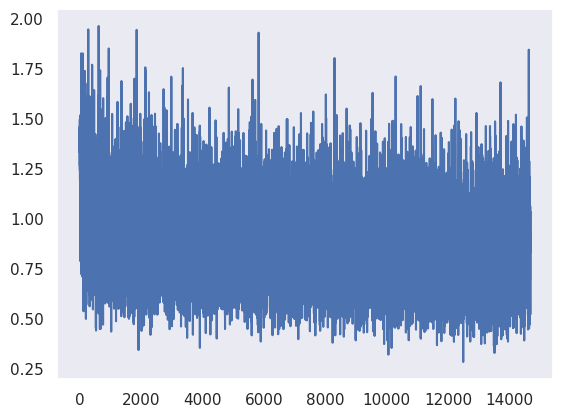

In [59]:
plt.plot(train_losses)

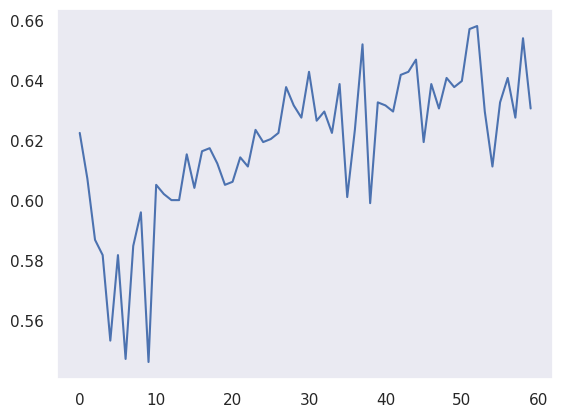

In [60]:
plt.plot(test_accuracy)

In [61]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 618/976 (0.6332)
{'acc_detail': tensor([0.7992, 0.5880, 0.8307, 0.3056], device='cuda:0'),
 'acc_unweighted': tensor(0.6309, device='cuda:0'),
 'acc_weighted': tensor(0.6332, device='cuda:0'),
 'f1s_detail': tensor([0.7519, 0.5359, 0.7365, 0.4219], device='cuda:0'),
 'f1s_unweighted': tensor(0.6115, device='cuda:0'),
 'f1s_weighted': tensor(0.6149, device='cuda:0'),
 'precision_detail': tensor([0.7098, 0.4922, 0.6614, 0.6814], device='cuda:0'),
 'recall_detail': tensor([0.7992, 0.5880, 0.8307, 0.3056], device='cuda:0'),
 'rocauc': tensor(0.8707, device='cuda:0'),
 'rocauc_detail': tensor([0.9221, 0.8303, 0.9161, 0.8141], device='cuda:0'),
 'uar': tensor(0.6309, device='cuda:0'),
 'wap': tensor(0.6417, device='cuda:0')}


tensor([[203,  20,   4,  27],
        [ 11, 127,  70,   8],
        [  5,  37, 211,   1],
        [ 67,  74,  34,  77]], device='cuda:0')

In [62]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m14sinc_improved_best_53epoch.pt
Correct: 645/976 (0.6609)
{'acc_detail': tensor([0.7126, 0.6111, 0.7520, 0.5595], device='cuda:0'),
 'acc_unweighted': tensor(0.6588, device='cuda:0'),
 'acc_weighted': tensor(0.6609, device='cuda:0'),
 'f1s_detail': tensor([0.7464, 0.5727, 0.7505, 0.5674], device='cuda:0'),
 'f1s_unweighted': tensor(0.6592, device='cuda:0'),
 'f1s_weighted': tensor(0.6628, device='cuda:0'),
 'precision_detail': tensor([0.7835, 0.5388, 0.7490, 0.5755], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.6111, 0.7520, 0.5595], device='cuda:0'),
 'rocauc': tensor(0.8772, device='cuda:0'),
 'rocauc_detail': tensor([0.9222, 0.8499, 0.9185, 0.8182], device='cuda:0'),
 'uar': tensor(0.6588, device='cuda:0'),
 'wap': tensor(0.6667, device='cuda:0')}


tensor([[181,  13,   3,  57],
        [  3, 132,  42,  39],
        [  5,  50, 191,   8],
        [ 42,  50,  19, 141]], device='cuda:0')

In [63]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_improved_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [64]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/40 [00:00<1:57:47, 176.70s/it]

Train Epoch: 61 [0/3918 (0%)]	Loss: 0.547185
Mem before-during-after: 655777280 4607119360 658951680


  0%|                                | 0.13442622950819672/40 [00:25<2:10:37, 196.59s/it]

Train Epoch: 61 [640/3918 (16%)]	Loss: 0.741570
Mem before-during-after: 658951680 4608375808 658951680


  1%|▏                               | 0.26557377049180286/40 [00:50<2:05:48, 189.98s/it]

Train Epoch: 61 [1280/3918 (33%)]	Loss: 0.717432
Mem before-during-after: 658951680 4608375808 658951680


  1%|▎                                  | 0.39672131147541/40 [01:15<2:08:22, 194.49s/it]

Train Epoch: 61 [1920/3918 (49%)]	Loss: 1.169768
Mem before-during-after: 658951680 4608375296 658951680


  1%|▍                                | 0.5278688524590167/40 [01:41<2:07:28, 193.77s/it]

Train Epoch: 61 [2560/3918 (66%)]	Loss: 1.176683
Mem before-during-after: 658951680 4608375808 658951680


  2%|▌                                | 0.6590163934426216/40 [02:06<2:07:18, 194.17s/it]

Train Epoch: 61 [3200/3918 (82%)]	Loss: 0.633952
Mem before-during-after: 658951680 4608375296 658951680


  2%|▋                                | 0.7901639344262266/40 [02:31<2:08:40, 196.90s/it]

Train Epoch: 61 [3840/3918 (98%)]	Loss: 1.002550
Mem before-during-after: 658951680 4608375808 658951680


  2%|▉                                   | 0.9999999999999944/40 [02:49<51:56, 79.91s/it]


Test Epoch: 61	Accuracy: 642/976 (66%)



  3%|▊                                | 1.0032786885245846/40 [02:50<1:11:03, 109.33s/it]

Train Epoch: 62 [0/3918 (0%)]	Loss: 1.321504
Mem before-during-after: 658950656 4610292736 658951680


  3%|▉                                | 1.1344262295081895/40 [03:15<2:04:07, 191.63s/it]

Train Epoch: 62 [640/3918 (16%)]	Loss: 0.916681
Mem before-during-after: 658951680 4608375296 658951680


  3%|█                                | 1.2655737704917944/40 [03:40<2:04:39, 193.11s/it]

Train Epoch: 62 [1280/3918 (33%)]	Loss: 0.984702
Mem before-during-after: 658951680 4608375808 658951680


  3%|█▏                               | 1.3967213114753994/40 [04:05<2:04:33, 193.60s/it]

Train Epoch: 62 [1920/3918 (49%)]	Loss: 0.972297
Mem before-during-after: 658951680 4608375296 658951680


  4%|█▎                               | 1.5278688524590043/40 [04:30<2:04:27, 194.09s/it]

Train Epoch: 62 [2560/3918 (66%)]	Loss: 0.976483
Mem before-during-after: 658951680 4608375808 658951680


  4%|█▎                               | 1.6590163934426092/40 [04:56<2:03:52, 193.86s/it]

Train Epoch: 62 [3200/3918 (82%)]	Loss: 1.123798
Mem before-during-after: 658951680 4608375296 658951680


  4%|█▍                               | 1.7901639344262141/40 [05:21<2:02:25, 192.25s/it]

Train Epoch: 62 [3840/3918 (98%)]	Loss: 0.741275
Mem before-during-after: 658951680 4608375296 658951680


  5%|█▊                                   | 1.999999999999982/40 [05:39<49:05, 77.52s/it]


Test Epoch: 62	Accuracy: 648/976 (66%)

saved model: ../models_cremad4/cremad_label4_m14sinc_improved_best_62epoch.pt


  5%|█▋                               | 2.0032786885245724/40 [05:39<1:08:05, 107.51s/it]

Train Epoch: 63 [0/3918 (0%)]	Loss: 0.763788
Mem before-during-after: 658950656 4610292736 658951680


  5%|█▊                               | 2.1344262295081773/40 [06:04<2:03:20, 195.45s/it]

Train Epoch: 63 [640/3918 (16%)]	Loss: 0.713426
Mem before-during-after: 658951680 4610355712 658952192


  6%|█▉                                | 2.265573770491782/40 [06:30<2:01:03, 192.49s/it]

Train Epoch: 63 [1280/3918 (33%)]	Loss: 0.969930
Mem before-during-after: 658951680 4608375808 658951680


  6%|██                                | 2.396721311475387/40 [06:55<2:06:30, 201.86s/it]

Train Epoch: 63 [1920/3918 (49%)]	Loss: 0.710196
Mem before-during-after: 658951680 4608375296 658951680


  6%|██▏                               | 2.527868852458992/40 [07:21<2:01:40, 194.84s/it]

Train Epoch: 63 [2560/3918 (66%)]	Loss: 0.884388
Mem before-during-after: 658951680 4582513664 658951680


  7%|██▎                               | 2.659016393442597/40 [07:46<2:00:12, 193.16s/it]

Train Epoch: 63 [3200/3918 (82%)]	Loss: 0.510882
Mem before-during-after: 658951680 4608375296 658951680


  7%|██▎                               | 2.790163934426202/40 [08:11<2:01:03, 195.20s/it]

Train Epoch: 63 [3840/3918 (98%)]	Loss: 0.825846
Mem before-during-after: 658951680 4608375296 658951680


  7%|██▊                                   | 2.99999999999997/40 [08:29<48:35, 78.80s/it]


Test Epoch: 63	Accuracy: 635/976 (65%)



  8%|██▋                                | 3.00327868852456/40 [08:29<1:06:31, 107.88s/it]

Train Epoch: 64 [0/3918 (0%)]	Loss: 0.754031
Mem before-during-after: 658950656 4610293248 658951680


  8%|██▋                               | 3.134426229508165/40 [08:55<1:58:57, 193.61s/it]

Train Epoch: 64 [640/3918 (16%)]	Loss: 0.836969
Mem before-during-after: 658951680 4608375808 658951680


  8%|██▊                                | 3.26557377049177/40 [09:20<2:00:00, 196.00s/it]

Train Epoch: 64 [1280/3918 (33%)]	Loss: 0.751175
Mem before-during-after: 658951680 4608375296 658951680


  8%|██▊                              | 3.3967213114753747/40 [09:46<1:59:02, 195.13s/it]

Train Epoch: 64 [1920/3918 (49%)]	Loss: 0.755675
Mem before-during-after: 658951680 4608375296 658951680


  9%|██▉                              | 3.5278688524589796/40 [10:11<1:58:13, 194.48s/it]

Train Epoch: 64 [2560/3918 (66%)]	Loss: 0.505875
Mem before-during-after: 658951680 4608320512 658951680


  9%|███                              | 3.6590163934425846/40 [10:36<1:56:38, 192.57s/it]

Train Epoch: 64 [3200/3918 (82%)]	Loss: 0.635150
Mem before-during-after: 658951680 4608375296 658951680


  9%|███▏                             | 3.7901639344261895/40 [11:02<1:57:53, 195.36s/it]

Train Epoch: 64 [3840/3918 (98%)]	Loss: 0.507070
Mem before-during-after: 658951680 4608375296 658951680


 10%|███▌                                | 3.9999999999999574/40 [11:19<46:29, 77.48s/it]


Test Epoch: 64	Accuracy: 615/976 (63%)



 10%|███▎                             | 4.0032786885245475/40 [11:20<1:04:23, 107.34s/it]

Train Epoch: 65 [0/3918 (0%)]	Loss: 1.068712
Mem before-during-after: 658950656 4610292736 658951680


 10%|███▌                              | 4.134426229508152/40 [11:45<1:54:28, 191.51s/it]

Train Epoch: 65 [640/3918 (16%)]	Loss: 0.491124
Mem before-during-after: 658951680 4608375296 658951680


 11%|███▋                              | 4.265573770491757/40 [12:10<1:53:26, 190.47s/it]

Train Epoch: 65 [1280/3918 (33%)]	Loss: 0.737459
Mem before-during-after: 658951680 4608375296 658951680


 11%|███▋                              | 4.396721311475362/40 [12:36<1:55:07, 194.00s/it]

Train Epoch: 65 [1920/3918 (49%)]	Loss: 0.800285
Mem before-during-after: 658951680 4608375808 658951680


 11%|███▊                              | 4.527868852458967/40 [13:01<1:55:33, 195.45s/it]

Train Epoch: 65 [2560/3918 (66%)]	Loss: 0.665164
Mem before-during-after: 658951680 4608375296 658951680


 12%|███▉                              | 4.659016393442572/40 [13:26<1:48:44, 184.62s/it]

Train Epoch: 65 [3200/3918 (82%)]	Loss: 0.735254
Mem before-during-after: 658951680 4524375552 658951680


 12%|████                              | 4.790163934426177/40 [13:52<2:17:32, 234.39s/it]

Train Epoch: 65 [3840/3918 (98%)]	Loss: 0.600044
Mem before-during-after: 658951680 4608375296 658951680


 12%|████▌                                | 4.999999999999945/40 [14:10<45:06, 77.33s/it]


Test Epoch: 65	Accuracy: 619/976 (63%)



 13%|████▎                             | 5.003278688524535/40 [14:10<1:03:35, 109.01s/it]

Train Epoch: 66 [0/3918 (0%)]	Loss: 0.642349
Mem before-during-after: 658950656 4610292736 658951680


 13%|████▍                              | 5.13442622950814/40 [14:35<1:52:13, 193.14s/it]

Train Epoch: 66 [640/3918 (16%)]	Loss: 0.712932
Mem before-during-after: 658951680 4608375808 658951680


 13%|████▍                             | 5.265573770491745/40 [15:01<1:47:48, 186.22s/it]

Train Epoch: 66 [1280/3918 (33%)]	Loss: 0.649089
Mem before-during-after: 658951680 4524375552 658951680


 13%|████▋                              | 5.39672131147535/40 [15:27<1:51:51, 193.95s/it]

Train Epoch: 66 [1920/3918 (49%)]	Loss: 0.619702
Mem before-during-after: 658951680 4608375296 658951680


 14%|████▋                             | 5.527868852458955/40 [15:52<1:52:08, 195.19s/it]

Train Epoch: 66 [2560/3918 (66%)]	Loss: 0.675518
Mem before-during-after: 658951680 4608320512 658951680


 14%|████▉                              | 5.65901639344256/40 [16:17<1:51:20, 194.52s/it]

Train Epoch: 66 [3200/3918 (82%)]	Loss: 1.256169
Mem before-during-after: 658951680 4608375296 658951680


 14%|████▉                             | 5.790163934426165/40 [16:43<1:47:46, 189.01s/it]

Train Epoch: 66 [3840/3918 (98%)]	Loss: 0.824615
Mem before-during-after: 658951680 4610417664 658951680


 15%|█████▍                              | 5.9999999999999325/40 [17:00<44:01, 77.69s/it]


Test Epoch: 66	Accuracy: 615/976 (63%)



 15%|█████                             | 6.003278688524523/40 [17:01<1:01:20, 108.28s/it]

Train Epoch: 67 [0/3918 (0%)]	Loss: 0.813083
Mem before-during-after: 658950656 4610292736 658951680


 15%|█████                            | 6.1344262295081275/40 [17:26<1:49:03, 193.22s/it]

Train Epoch: 67 [640/3918 (16%)]	Loss: 0.788662
Mem before-during-after: 658951680 4608375296 658951680


 16%|█████▏                           | 6.2655737704917325/40 [17:51<1:48:49, 193.56s/it]

Train Epoch: 67 [1280/3918 (33%)]	Loss: 0.889732
Mem before-during-after: 658951680 4608375296 658951680


 16%|█████▍                            | 6.396721311475337/40 [18:17<1:48:20, 193.46s/it]

Train Epoch: 67 [1920/3918 (49%)]	Loss: 0.605156
Mem before-during-after: 658951680 4608375296 658951680


 16%|█████▌                            | 6.527868852458942/40 [18:42<1:49:35, 196.43s/it]

Train Epoch: 67 [2560/3918 (66%)]	Loss: 0.815688
Mem before-during-after: 658951680 4608375808 658951680


 17%|█████▋                            | 6.659016393442547/40 [19:07<1:48:37, 195.49s/it]

Train Epoch: 67 [3200/3918 (82%)]	Loss: 1.019946
Mem before-during-after: 658951680 4608375296 658951680


 17%|█████▊                            | 6.790163934426152/40 [19:33<1:46:22, 192.19s/it]

Train Epoch: 67 [3840/3918 (98%)]	Loss: 1.012887
Mem before-during-after: 658951680 4608375296 658951680


 17%|██████▋                               | 6.99999999999992/40 [19:50<42:42, 77.66s/it]


Test Epoch: 67	Accuracy: 599/976 (61%)



 18%|██████▋                               | 7.00327868852451/40 [19:51<48:40, 88.52s/it]

Train Epoch: 68 [0/3918 (0%)]	Loss: 0.973803
Mem before-during-after: 658950656 4061472256 658951680


 18%|██████                            | 7.134426229508115/40 [20:16<1:53:39, 207.49s/it]

Train Epoch: 68 [640/3918 (16%)]	Loss: 0.663327
Mem before-during-after: 658951680 4608375296 658951680


 18%|██████▎                            | 7.26557377049172/40 [20:41<1:41:49, 186.64s/it]

Train Epoch: 68 [1280/3918 (33%)]	Loss: 0.895389
Mem before-during-after: 658951680 4551348736 658951680


 18%|██████▎                           | 7.396721311475325/40 [21:07<1:44:52, 193.00s/it]

Train Epoch: 68 [1920/3918 (49%)]	Loss: 0.861189
Mem before-during-after: 658951680 4608375808 658951680


 19%|██████▌                            | 7.52786885245893/40 [21:32<1:44:31, 193.14s/it]

Train Epoch: 68 [2560/3918 (66%)]	Loss: 0.820918
Mem before-during-after: 658951680 4608394752 658951680


 19%|██████▌                           | 7.659016393442535/40 [21:57<1:39:03, 183.79s/it]

Train Epoch: 68 [3200/3918 (82%)]	Loss: 0.603316
Mem before-during-after: 658951680 4524375552 658951680


 19%|██████▊                            | 7.79016393442614/40 [22:23<1:44:06, 193.93s/it]

Train Epoch: 68 [3840/3918 (98%)]	Loss: 0.602141
Mem before-during-after: 658951680 4608375296 658951680


 20%|███████▍                             | 7.999999999999908/40 [22:41<41:02, 76.95s/it]


Test Epoch: 68	Accuracy: 616/976 (63%)



 20%|███████▏                            | 8.003278688524498/40 [22:41<57:01, 106.94s/it]

Train Epoch: 69 [0/3918 (0%)]	Loss: 0.765595
Mem before-during-after: 658950656 4571784192 658951680


 20%|██████▉                           | 8.134426229508103/40 [23:06<1:43:19, 194.54s/it]

Train Epoch: 69 [640/3918 (16%)]	Loss: 1.093196
Mem before-during-after: 658951680 4608375296 658951680


 21%|███████                           | 8.265573770491708/40 [23:32<1:42:05, 193.02s/it]

Train Epoch: 69 [1280/3918 (33%)]	Loss: 0.856505
Mem before-during-after: 658951680 4608375808 658951680


 21%|███████▏                          | 8.396721311475313/40 [23:57<1:42:04, 193.79s/it]

Train Epoch: 69 [1920/3918 (49%)]	Loss: 0.680139
Mem before-during-after: 658951680 4608375296 658951680


 21%|███████▏                          | 8.527868852458917/40 [24:22<1:40:30, 191.61s/it]

Train Epoch: 69 [2560/3918 (66%)]	Loss: 0.992467
Mem before-during-after: 658951680 4608375296 658951680


 22%|███████▎                          | 8.659016393442522/40 [24:47<1:41:11, 193.72s/it]

Train Epoch: 69 [3200/3918 (82%)]	Loss: 0.785610
Mem before-during-after: 658951680 4608375296 658951680


 22%|███████▍                          | 8.790163934426127/40 [25:12<1:41:03, 194.28s/it]

Train Epoch: 69 [3840/3918 (98%)]	Loss: 0.543683
Mem before-during-after: 658951680 4608375296 658951680


 22%|████████▎                            | 8.999999999999895/40 [25:30<41:38, 80.60s/it]


Test Epoch: 69	Accuracy: 626/976 (64%)



 23%|████████                            | 9.003278688524485/40 [25:30<56:22, 109.14s/it]

Train Epoch: 70 [0/3918 (0%)]	Loss: 1.011087
Mem before-during-after: 658950656 4610292736 658951680


 23%|███████▉                           | 9.13442622950809/40 [25:56<1:37:38, 189.82s/it]

Train Epoch: 70 [640/3918 (16%)]	Loss: 1.155958
Mem before-during-after: 658951680 4608320512 658951680


 23%|███████▉                          | 9.265573770491695/40 [26:21<1:38:57, 193.18s/it]

Train Epoch: 70 [1280/3918 (33%)]	Loss: 0.757226
Mem before-during-after: 658951680 4608375296 658951680


 23%|████████▍                           | 9.3967213114753/40 [26:46<1:36:30, 189.22s/it]

Train Epoch: 70 [1920/3918 (49%)]	Loss: 0.887067
Mem before-during-after: 658951680 4608375296 658951680


 24%|████████                          | 9.527868852458905/40 [27:11<1:38:29, 193.94s/it]

Train Epoch: 70 [2560/3918 (66%)]	Loss: 0.938491
Mem before-during-after: 658951680 4608375296 658951680


 24%|████████▍                          | 9.65901639344251/40 [27:37<1:37:33, 192.94s/it]

Train Epoch: 70 [3200/3918 (82%)]	Loss: 0.789413
Mem before-during-after: 658951680 4608375296 658951680


 24%|████████▎                         | 9.790163934426115/40 [28:02<1:38:00, 194.67s/it]

Train Epoch: 70 [3840/3918 (98%)]	Loss: 0.892551
Mem before-during-after: 658951680 4608375296 658951680


 25%|█████████▏                           | 9.999999999999883/40 [28:20<39:10, 78.35s/it]


Test Epoch: 70	Accuracy: 613/976 (63%)



 25%|████████▊                          | 10.003278688524473/40 [28:20<58:11, 116.40s/it]

Train Epoch: 71 [0/3918 (0%)]	Loss: 0.853631
Mem before-during-after: 658950656 4610292736 658951680


 25%|████████▎                        | 10.134426229508078/40 [28:46<1:36:54, 194.68s/it]

Train Epoch: 71 [640/3918 (16%)]	Loss: 0.697975
Mem before-during-after: 658951680 4608375808 658951680


 26%|████████▍                        | 10.265573770491683/40 [29:11<1:38:21, 198.48s/it]

Train Epoch: 71 [1280/3918 (33%)]	Loss: 0.688337
Mem before-during-after: 658951680 4608375808 658951680


 26%|████████▌                        | 10.396721311475288/40 [29:37<1:36:44, 196.08s/it]

Train Epoch: 71 [1920/3918 (49%)]	Loss: 0.955173
Mem before-during-after: 658951680 4608375296 658951680


 26%|████████▋                        | 10.527868852458893/40 [30:01<1:30:29, 184.21s/it]

Train Epoch: 71 [2560/3918 (66%)]	Loss: 0.849538
Mem before-during-after: 658951680 4608375808 658951680


 27%|████████▊                        | 10.659016393442498/40 [30:25<1:32:25, 188.99s/it]

Train Epoch: 71 [3200/3918 (82%)]	Loss: 0.779154
Mem before-during-after: 658951680 4608375296 658951680


 27%|████████▉                        | 10.790163934426102/40 [30:49<1:31:05, 187.11s/it]

Train Epoch: 71 [3840/3918 (98%)]	Loss: 0.921906
Mem before-during-after: 658951680 4608375808 658951680


 27%|██████████▏                          | 10.99999999999987/40 [31:07<39:10, 81.06s/it]


Test Epoch: 71	Accuracy: 606/976 (62%)



 28%|█████████▉                          | 11.00327868852446/40 [31:08<52:51, 109.38s/it]

Train Epoch: 72 [0/3918 (0%)]	Loss: 0.813534
Mem before-during-after: 658950656 4610292736 658951680


 28%|█████████▏                       | 11.134426229508065/40 [31:33<1:38:46, 205.30s/it]

Train Epoch: 72 [640/3918 (16%)]	Loss: 0.633332
Mem before-during-after: 658951680 4608375808 658951680


 28%|█████████▎                       | 11.213114754098228/40 [31:49<1:21:42, 170.30s/it]


UnboundLocalError: local variable 'data' referenced before assignment

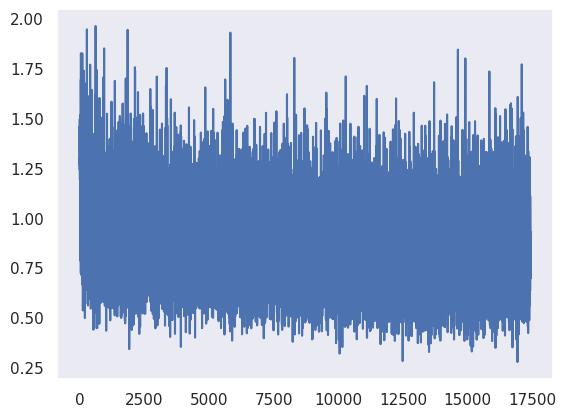

In [68]:
plt.plot(train_losses)

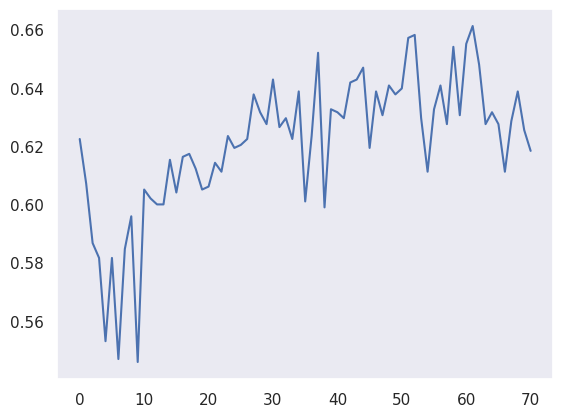

In [69]:
plt.plot(test_accuracy)

In [76]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_improved_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [42]:
model

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [43]:
from IConNet.visualizer import display_module

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



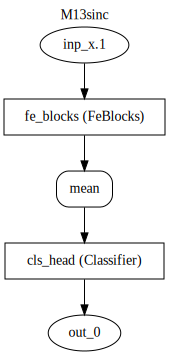

In [44]:
input_shape = (1,1,16000)
best_model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



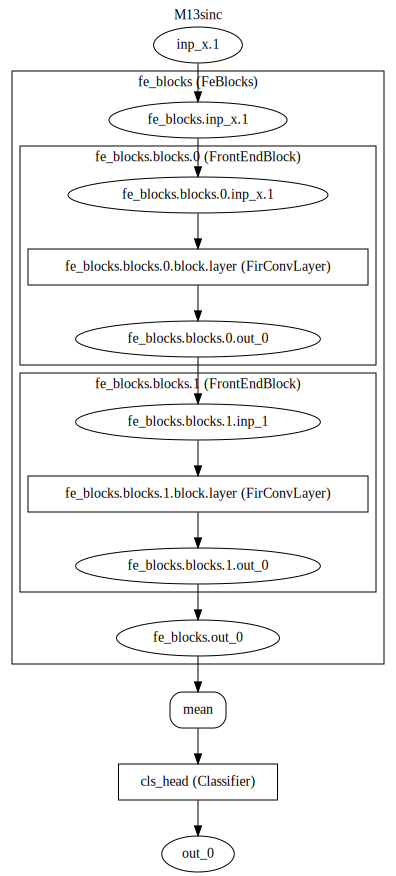

In [45]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock"})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



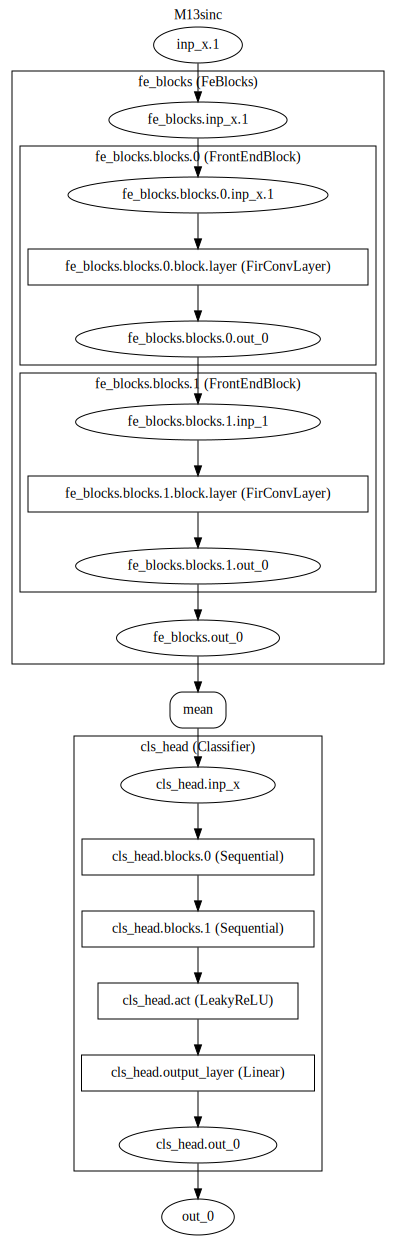

In [46]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock", "Classifier"})

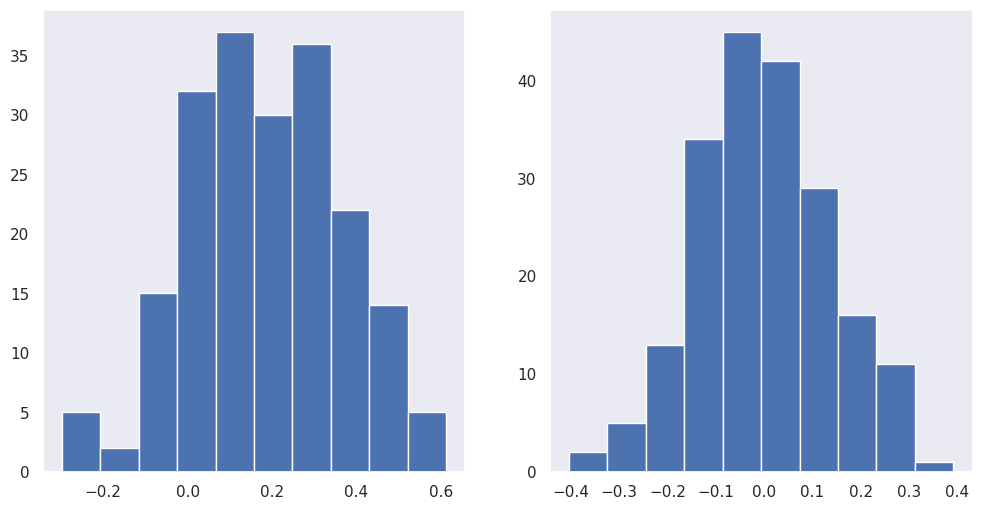

In [50]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

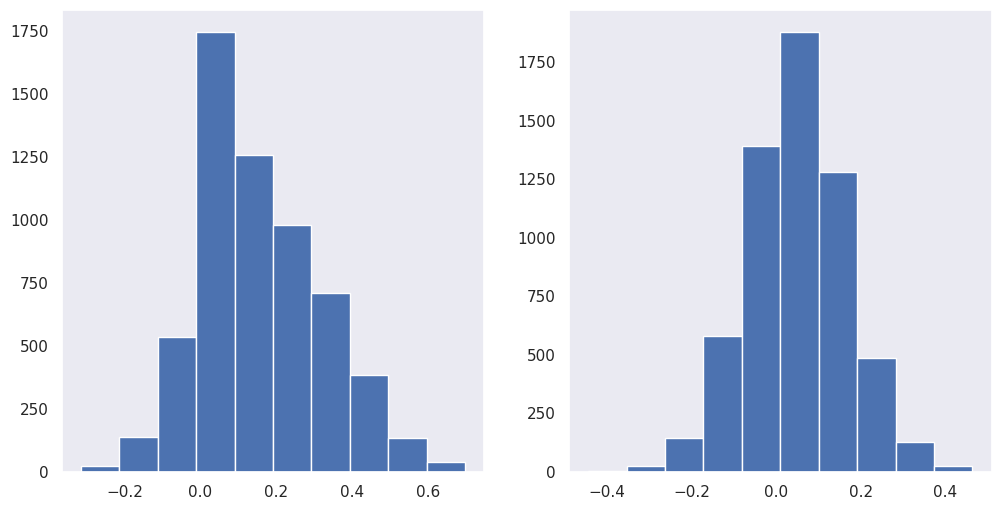

In [51]:
layer2 = best_model.fe_blocks.blocks[1].block.layer

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz2.visualize_bands()

In [52]:
del model
del best_model
gc.collect()

19668